In [1]:
import os
import rasterio.mask
import re
import shapely

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import networkx as nx
import numpy as np
import osmnx as ox
import pandana as pdna
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import rasterio as rio
import seaborn as sns

from dotenv import load_dotenv
from pathlib import Path
from scipy.interpolate import griddata
from shapely.plotting import plot_points, plot_polygon
from typing import Optional

load_dotenv()

True

In [2]:
YEARS = list(range(1975, 2021, 5))
met_zone = "02.2.03"

In [3]:
ghsl_path = Path(os.environ["GHSL_PATH"])
population_grids_path = Path(os.environ["GRID_PATH"]) / "final"
census_path = Path(os.environ["CENSUS_PATH"])
segregation_path = Path(os.environ["SEGREGATION_PATH"])
data_path = Path(os.environ["DATA_PATH"])
framework_path = Path(os.environ["FRAMEWORK_PATH"])

In [4]:
lims = gpd.read_file(data_path / "lim_aumxl24/lim_aumxl24.shp").to_crs("EPSG:6372")["geometry"].item()

In [5]:
df = gpd.read_file(population_grids_path / f"reprojected/base/2020/{met_zone}.gpkg").set_index("codigo")["geometry"]

In [6]:
idx_lost = gpd.read_file(population_grids_path / f"differences/2000_2020/{met_zone}.gpkg").query("difference < 0")["codigo"].values

In [7]:
df_built = []
for year in YEARS:
    with rio.open(ghsl_path / f"BUILT_100/{year}.tif", nodata=65535) as ds:
        for idx, geom in df.to_crs("ESRI:54009").items():
            masked, _ = rio.mask.mask(ds, [geom], crop=True, nodata=0, pad=True)
            masked[masked == 65535] = 0
            masked = masked.squeeze()
            df_built.append(dict(
                index=idx,
                year=year,
                built=masked.sum()
            ))
df_built = pd.DataFrame(df_built).pivot(index="index", columns="year", values="built")

for year in YEARS:
    df_built[year] = df_built[year] / df.area
df_built = df_built > 0.2

In [8]:
test = df_built.copy()
test = test.replace(False, np.nan)
test = test.idxmax(axis=1).dropna().astype(int)
test.name = "year"

C:\Users\lain\AppData\Local\Temp\ipykernel_14596\1483527884.py:3: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  test = test.idxmax(axis=1).dropna().astype(int)


In [9]:
urb_year_df = pd.concat([df, test], axis=1, join="inner")
urb_year_df = gpd.GeoDataFrame(urb_year_df, crs=df.crs, geometry="geometry")

In [10]:
wanted_df = urb_year_df.query("(year <= 1990) and (index.isin(@idx_lost))")
wanted_df = wanted_df[wanted_df["geometry"].intersects(lims)]

In [11]:
union_geom = wanted_df["geometry"].copy()
union_geom = union_geom.buffer(1, join_style="mitre", cap_style="flat")
union_geom = shapely.union_all(union_geom)

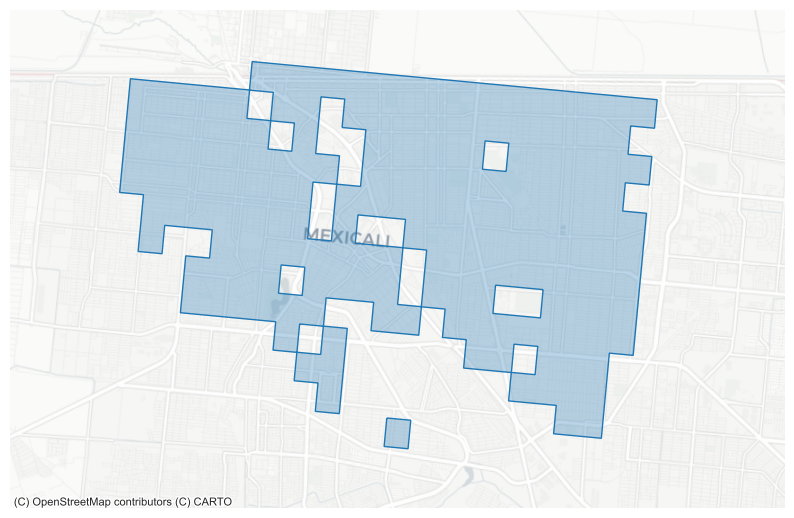

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_polygon(union_geom, add_points=False)
ax.set_xlim(1.222e6, 1.236e6)
ax.set_ylim(2.341e6, 2.350e6)
ax.grid(False)
ax.axis("off")
cx.add_basemap(ax, zoom=13, crs=wanted_df.crs, source=cx.providers.CartoDB.Positron)

# AGEBs

In [13]:
agebs = gpd.read_file(population_grids_path / "framework/agebs/2020.gpkg")

intersect_agebs = agebs[agebs.intersects(union_geom)]
forced_agebs = agebs[agebs["CVEGEO"].isin(["0200200012886", "0200200012833", "0200200014774", "0200200014789"])]

wanted_agebs = (
    pd.concat([intersect_agebs, forced_agebs])
    .drop(columns=["CVE_ENT", "CVE_MUN", "CVE_LOC", "CVE_AGEB", "NOM_ENT", "NOM_MUN", "POBTOT"], errors="ignore")
    .set_index("CVEGEO")
)

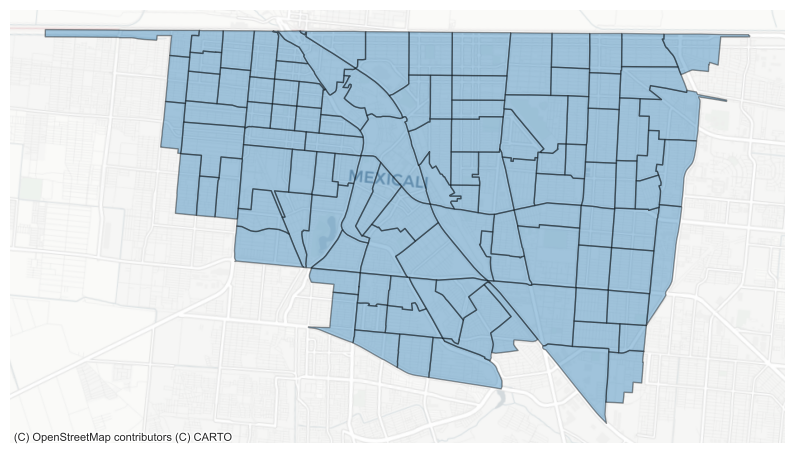

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
wanted_agebs.plot(ax=ax, fc="C0", alpha=0.4, ec="k")
ax.axis("off")
cx.add_basemap(ax, crs=wanted_agebs.crs, source=cx.providers.CartoDB.Positron)
# fig.savefig("./figures/wanted_agebs.png", bbox_inches="tight", dpi=200)

# Stats

In [15]:
fpath = segregation_path / "incomes/M02.02.gpkg"
df_income = gpd.read_file(fpath).set_index("cvegeo").drop(columns=["geometry"])

In [16]:
state_code, *_ = met_zone.split(".")
df_census = (
    pd.read_csv(
        census_path / f"{state_code}.csv", 
        usecols=[
            "ENTIDAD", 
            "MUN", 
            "LOC", 
            "AGEB", 
            "NOM_LOC", 
            "VIVPAR_DES", 
            "GRAPROES", 
            "VIVTOT",
            "POBTOT",
            "VPH_INTER",
            "P_60YMAS"
        ], 
        na_values=["*", "N/D"],
        dtype={
            "GRAPROES": float,
            "VIVTOT": float,
            "VIVPAR_DES": float,
            "POBTOT": float
        }
    )
    .assign(
        frac_viv_deshab=lambda x: x.VIVPAR_DES / x.VIVTOT,
        frac_viv_inter=lambda x: x.VPH_INTER / x.VIVTOT,
        CVEGEO=lambda x: (
            x.ENTIDAD.astype(str).str.rjust(2, "0")
            + x.MUN.astype(str).str.rjust(3, "0")
            + x.LOC.astype(str).str.rjust(4, "0")
            + x.AGEB.astype(str).str.rjust(4, "0")
        )
    )
    .set_index("CVEGEO")
    .join(wanted_agebs, how="inner")
    .join(df_income, how="inner")
    .query("NOM_LOC == 'Total AGEB urbana'")
    .drop(columns=[
        "VIVTOT", 
        "VIVPAR_DES", 
        "VPH_INTER", 
        "ENTIDAD", 
        "MUN", 
        "LOC", 
        "AGEB", 
        "NOM_LOC"
    ])
)
df_census = (
    gpd.GeoDataFrame(df_census)
    .assign(
        pop_dens=lambda x: x.POBTOT / x.area * 1e6,
        over_60_frac=lambda x: x.P_60YMAS / x.POBTOT
    )
    .drop(columns=["P_60YMAS"])
)

df_plot = df_census.rename(columns={
    "GRAPROES": "Grado promedio\nde escolaridad",
    "frac_viv_deshab": "Fracción de viviendas\ndeshabitadas",
    "frac_viv_pc": "Fracción de\nviviendas con una\ncomputadora/celular/tablet",
    "frac_viv_inter": "Fracción de\nviviendas con internet",
    "pop_dens": "Densidad de población",
    "income_pc": "Ingreso anual per cápita"
})

In [17]:
df_norm = []
for col in df_census.drop(columns=["geometry"]).columns:
    series = df_census[col]
    series = (series - series.min()) / (series.max() - series.min())
    df_norm.append(series)
df_norm = pd.concat(df_norm, axis=1) 

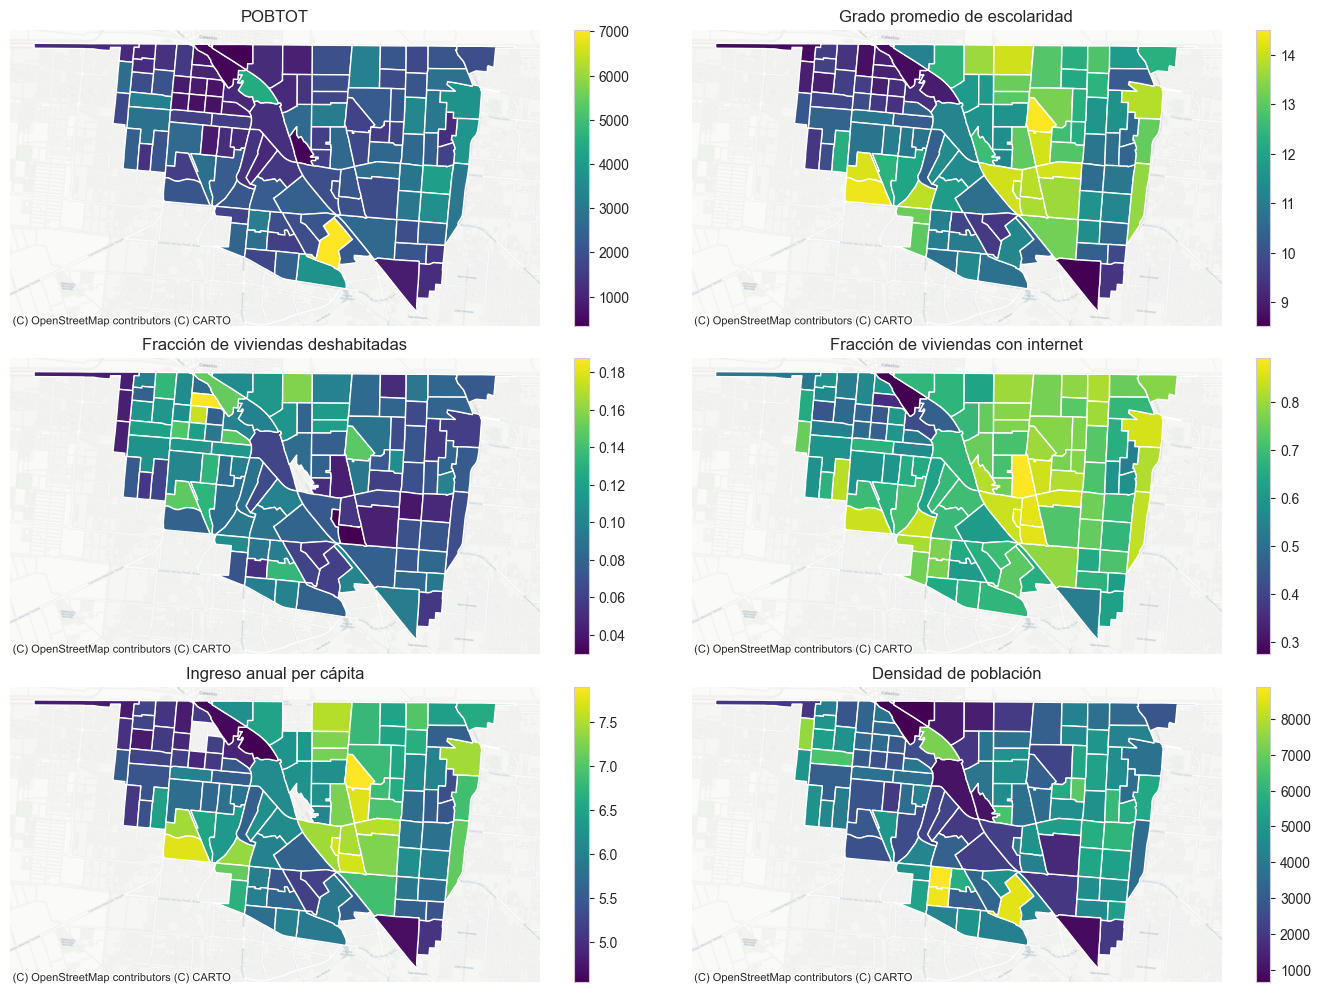

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(14, 10))
for col, ax in zip(df_plot.drop(columns=["geometry"]).columns, axes.flat):
    df_plot.plot(column=col, ax=ax, legend=True, legend_kwds={"shrink": 1}, cmap="viridis"
)
    ax.set_title(col.replace("\n", " "))
    ax.axis("off")
    cx.add_basemap(ax=ax, crs=df_plot.crs, source=cx.providers.CartoDB.Positron, zoom=14)
axes[-1, -1].axis("off")
fig.tight_layout()

# Isochrones

In [19]:
jobs = (
    gpd.read_file(data_path / "jobs/2023.geojson")
    .to_crs("EPSG:6372")
)
jobs = jobs[jobs.intersects(lims)]

In [20]:
bounds_latlon = gpd.GeoSeries([lims], crs="EPSG:6372").to_crs("EPSG:4326").total_bounds

ox.settings.bidirectional_network_types = ["walk"]

g = ox.graph_from_bbox(bbox=bounds_latlon, network_type="drive")
g = ox.add_edge_speeds(g)
g = ox.add_edge_travel_times(g)

In [21]:
TRAVEL_SPEED = 40 * 5 / 18

nodes, edges = ox.graph_to_gdfs(g)
nodes = nodes.drop(columns=["x", "y", "street_count", "highway", "railway"])
edges = edges.reset_index()[["u", "v", "length"]].copy()

travel_df, centroids = [], []
for i, geom in df_census["geometry"].to_crs("EPSG:4326").items():
    (x, ), (y, ) = geom.centroid.coords.xy
    nearest_node = ox.nearest_nodes(g, x, y)
    centroids.append((x, y))
        
    travel_lengths = nx.shortest_path_length(g, nearest_node, weight="length")
    travel_times = {key: value / TRAVEL_SPEED for key, value in travel_lengths.items()}

    temp = nodes.join(pd.Series(travel_times, name="travel_time"), how="inner")
    temp["id"] = i
    travel_df.append(temp)

travel_df = pd.concat(travel_df).to_crs("EPSG:6372")

In [22]:
temp = jobs.copy()
temp["geometry"] = temp.centroid
jobs_travel = temp.sjoin_nearest(travel_df, how="inner")
jobs_frac = (
    jobs_travel
    .query("travel_time < 20 * 60")
    .groupby("id")
    ["num_empleos"]
    .sum()
) / (
    jobs["num_empleos"]
    .sum()
)

df_census["job_frac"] = jobs_frac

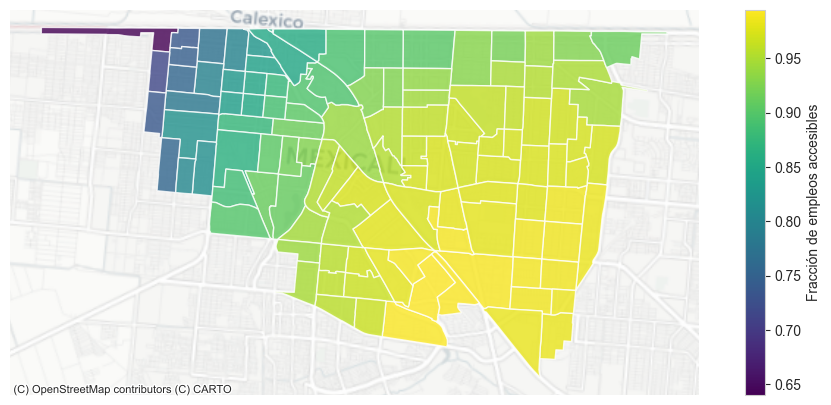

In [23]:
fig, ax = plt.subplots(figsize=(12, 5))
df_census.plot(column="job_frac", legend=True, ax=ax, legend_kwds={"label": "Fracción de empleos accesibles"}, alpha=0.8, cmap="viridis")
ax.axis("off")
cx.add_basemap(ax=ax, crs="EPSG:6372", source=cx.providers.CartoDB.Positron, zoom=12)
# fig.savefig("./figures/job_frac.png", bbox_inches="tight", dpi=200)

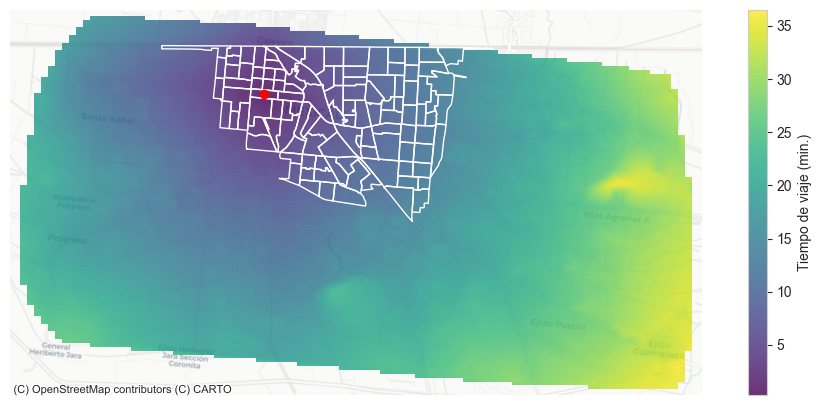

In [24]:
ids = travel_df["id"].unique()
i = 10
chosen_id = ids[i]

data = (
    travel_df
    .query(f"id == '{chosen_id}'")
    .assign(
        x=lambda x: x.geometry.x,
        y=lambda x: x.geometry.y
    )
    .drop(columns=["geometry"])
)

x = np.linspace(data["x"].min(), data["x"].max(), 100)
y = np.linspace(data["y"].min(), data["y"].max(), 100)

xx, yy = np.meshgrid(x, y)
z = griddata(data[["x", "y"]].to_numpy(), data["travel_time"].to_numpy() / 60, (xx, yy))

fig, ax = plt.subplots(figsize=(12, 5))
ax.imshow(z, cmap="viridis", interpolation="bilinear", extent=(x.min(), x.max(), y.min(), y.max()), alpha=0.8, origin="lower")
cx.add_basemap(ax=ax, crs="EPSG:6372", source=cx.providers.CartoDB.Positron, zoom=12)
c = ax.imshow(z, cmap="viridis", interpolation="bilinear", extent=(x.min(), x.max(), y.min(), y.max()), alpha=0.8, origin="lower")
cbar = fig.colorbar(c)
cbar.set_label("Tiempo de viaje (min.)")
df_census.plot(ax=ax, fc="none")
ax.axis("off")
plot_points(df_census.centroid.loc[chosen_id], color="r")
# fig.savefig("./figures/travel_time.png", bbox_inches="tight", dpi=200)

# Equip

In [25]:
equipment_path = data_path / "equipamiento"

equipments = []
for path in equipment_path.glob("*.shp"):
    if path.is_dir():
        continue
    
    equip_type = re.sub(r"equip_", "", path.stem)

    temp_df = (
        gpd.read_file(path)
        .assign(geometry=lambda x: gpd.points_from_xy(x.geometry.x, x.geometry.y))
        .to_crs("EPSG:6372")
    )
    temp_df["type"] = equip_type
    equipments.append(temp_df)

equipments = (
    pd.concat(equipments, ignore_index=True)
    [["COMPONENTE", "type", "TIPO", "geometry"]]
    .copy()
)

In [26]:
wanted_types = {
    "salud": None, 
    "edu_basica": None, 
    "edu_sup": None,
    "med_sup": None,
    "cult_rec": "COMPONENTE == 'BASICO'",
    "deporte": "COMPONENTE == 'BASICO'",
    "asist_social": "COMPONENTE == 'BASICO'"
}

wanted_equipments = []
for t, query in wanted_types.items():
    if query is None:
        full_query = f"(type == '{t}')"
    else:
        full_query = f"(type == '{t}') & ({query})"

    temp_df = equipments.query(full_query)
    wanted_equipments.append(temp_df)

wanted_equipments = pd.concat(wanted_equipments)

In [27]:
equipment_counts = (
    df_census
    .sjoin(wanted_equipments, predicate="contains", how="inner")
    .groupby(level=0)
    ["type"]
    .value_counts()
    .reset_index()
    .pivot(index="CVEGEO", columns="type", values="count")
)
equipment_counts.columns = ["equip_" + c for c in equipment_counts.columns]
equipment_counts_reduced = equipment_counts.sum(axis=1)

df_census["num_equip"] = equipment_counts_reduced

# Prediums

## Clean

In [28]:
pred_clean = (
    gpd.read_file(data_path / "PRED_CAT_CP/PREDIOS_CAT_CP.shp")
    .to_crs("EPSG:6372")
    .assign(Uso=lambda df: df["Uso"].replace({
        "COEMERCIAL": "COMERCIAL",
        "COEMRCIAL": "COMERCIAL",
        "COMERCIA": "COMERCIAL",
        "COMERCIAL|": "COMERCIAL",
        "COMERCIO": "COMERCIAL",
        "COMERIAL": "COMERCIAL",
        "COMERICAL": "COMERCIAL",
        "INDISTRIAL": "INDUSTRIAL",
        "INDUATRIAL": "INDUSTRIAL",
        "INDUSRTIAL": "INDUSTRIAL",
        "INDUSTRIAL": "INDUSTRIAL",
        "PARFTICULAR": "PARTICULAR",
        "PARICULAR": "PARTICULAR",
        "PARITCULAR": "PARTICULAR",
        "PARTCULAR": "PARTICULAR",
        "PARTICUAR": "PARTICULAR",
        "PARTICULAL": "PARTICULAR",
        "PARTICULARPARTICULAR": "PARTICULAR",
        "PARTICULR": "PARTICULAR",
        "PARTICYULAR": "PARTICULAR",
        "PARTIULAR": "PARTICULAR",
        "PARTUCULAR": "PARTICULAR",
        "PATICULAR": "PARTICULAR",
        "PQRTICULAR": "PARTICULAR",
        "PERSONAL": "PARTICULAR",
        "PRIVADO": "PARTICULAR"
    }))
)
# pred_clean.to_file("./pred_clean.gpkg")

C:\Users\lain\Documents\mexicali-zone\.venv\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: C:\Users\lain\OneDrive - Instituto Tecnologico y de Estudios Superiores de Monterrey\mexicali_data\PRED_CAT_CP\PREDIOS_CAT_CP.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


## Total area

In [29]:
total_pred_area = (
    df_census
    .reset_index()
    [["CVEGEO", "geometry"]]
    .overlay(pred_clean[["geometry"]], how="intersection")
    .assign(area=lambda df:df.geometry.area)
    .groupby("CVEGEO")
    ["area"]
    .sum()
)

C:\Users\lain\Documents\mexicali-zone\.venv\Lib\site-packages\geopandas\geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 27 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


# Recreational

In [30]:
public_spaces = (
    gpd.read_file(data_path / "esp_pub/esp_pub.shp")
    .to_crs("EPSG:6372")
    .assign(
        radius=lambda df: np.sqrt(df.Sup_M2 / np.pi),
        geometry=lambda df: df.apply(lambda x: x.geometry.buffer(x.radius, resolution=64), axis=1)
    )
)

In [31]:
overlay = (
    df_census
    .reset_index()
    .overlay(public_spaces[["geometry"]])
    .assign(area=lambda x: x.area)
    .groupby("CVEGEO")
    ["area"]
    .sum()
    .rename_axis("rec_area")
    .fillna(0)
)

df_census["rec_area"] = (overlay / total_pred_area).fillna(0)

# DENUE

In [111]:
denue_base = gpd.GeoDataFrame(
    (
        pd.read_csv(
            data_path / "denue.csv",
            encoding="latin1",
            # usecols=["codigo_act", "longitud", "latitud", "municipio", "per_ocu", "clee"]
        )
        .query("municipio == 'Mexicali'")
        .assign(geometry=lambda x: gpd.points_from_xy(x.longitud, x.latitud))
        .drop(columns=["municipio"])
        .set_index("clee")
    ),
    crs="EPSG:4326",
    geometry="geometry"
).to_crs("EPSG:6372")

# Anchors

In [33]:
anchors_equip = (
    equipments
    .query("((type == 'deporte') | (type == 'cult_rec')) & (COMPONENTE == 'ESPECIALIZADO')")
)

anchors_denue = (
    denue_base.query("(codigo_act == 462210) | (codigo_act == 522110)")
)

anchors = pd.concat([anchors_equip[["geometry"]], anchors_denue[["geometry"]]], ignore_index=True)

anchor_count = (
    df_census
    .sjoin(anchors, how="inner", predicate="contains")
    .groupby(level=0)
    ["index_right"]
    .count()
    .fillna(0)
)

df_census["num_anchor"] = anchor_count
df_census["num_anchor"] = df_census["num_anchor"].fillna(0)

# Small business

In [34]:
employee_map = {
    "0 a 5 personas": 2.5,
    "6 a 10 personas": 8,
    "11 a 30 personas": 20.5,
    "31 a 50 personas": 40.5,
    "51 a 100 personas": 75.5,
    "101 a 250 personas": 175.5,
    "251 y más personas": 300,
}

df_employee_small = (
    denue_base
    .loc[denue_base["codigo_act"].astype(str).str.match(r"^46"), ["per_ocu", "geometry"]]
    .assign(per_ocu=lambda df: df.per_ocu.map(employee_map))
)    

df_census["small_employee_density"] = (
    df_census
    .sjoin(
        df_employee_small,
        how="inner",
        predicate="contains"
    )
    .groupby(level=0)
    ["per_ocu"]
    .sum()
)

df_census["small_employee_density"] = df_census["small_employee_density"] / df_census.area * 1e6

# Value

In [35]:
values = (
    gpd.read_file(data_path / "valor_cat_actualizado/valor_cat_au24.shp")
    .to_crs("EPSG:6372")
)

In [36]:
grouped = (
    df_census[["geometry"]]
    .reset_index()
    .overlay(values[["valor2024", "geometry"]])
    .assign(weighted_value=lambda x: x.geometry.area * x.valor2024, area=lambda x: x.geometry.area)
    .groupby("CVEGEO")
)
total_area = grouped["area"].sum()
total_value = grouped["weighted_value"].sum()
final_value = total_value / total_area

df_census["average_value"] = final_value

# Average size

In [37]:
private_pred = (
    pred_clean
    .query("Uso == 'PARTICULAR'")
    [["geometry"]]
    .copy()
)

In [38]:
median_private_area = (
    df_census
    .reset_index()
    [["CVEGEO", "geometry"]]
    .overlay(private_pred[["geometry"]], how="intersection")
    .assign(area=lambda df:df.geometry.area)
    .groupby("CVEGEO")
    ["area"]
    .median()
)
df_census["median_area"] = median_private_area

C:\Users\lain\Documents\mexicali-zone\.venv\Lib\site-packages\geopandas\geodataframe.py:2675: UserWarning: `keep_geom_type=True` in overlay resulted in 23 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  return geopandas.overlay(


# Bare

In [39]:
bare = (
    gpd.read_file(data_path / "baldios/baldios_sector.shp")
    .to_crs("EPSG:6372")
)

bare_area = (
    df_census[["geometry"]].reset_index()
    .overlay(bare[["geometry"]])
    .assign(area=lambda x: x.geometry.area)
    .groupby("CVEGEO")
    ["area"]
    .sum()
)

df_census["bare_frac"] = bare_area / total_pred_area

# Gravity

## Amenities

### DENUE

In [40]:
def process_occupancy(x: str) -> str:
    matches = re.match(r'([0-9]+) a ([0-9]+) personas', x.strip())
    out = (int(matches.groups()[0]) + int(matches.groups()[1])) / 2 if matches else matches
    return out

In [41]:
SECTORS_MAP = [
    {"range": [(11, 11)], "sector": "primario"},
    {"range": [(21, 33)], "sector": "industria"},
    {"range": [(43, 46)], "sector": "comercio"},
    {"range": [(51, 56)], "sector": "oficina"},
    {"range": [(48, 49), (81, 81)], "sector": "servicios"},
    {"range": [(62, 62)], "sector": "salud"},
    {"range": [(61, 61)], "sector": "educacion"},
    {"range": [(72, 72)], "sector": "comercio"},
    {"range": [(73, 100)], "sector": "gubernamental"},
]

DENUE_TO_AMENITY_MAPPING = [
    # Salud
    {
        "name": "Consultorios médicos",
        "query": 'codigo_act.str.match("^621")',
    },
    {
        "name": "Hospital general",
        "query": 'codigo_act.str.match("^622")',
    },
    {
        "name": "Farmacia",
        "query": 'codigo_act.str.match("^46411")',
    },
    # Recreativo
    {
        "name": "Cine",
        "query": 'codigo_act.str.match("^51213")',
    },
    {
        "name": "Otros servicios recreativos",
        "query": 'codigo_act.str.match("^(71399|712|713)")',
    },
    {
        "name": "Clubs deportivos y de acondicionamiento físico",
        "query": 'codigo_act.str.match("^(71391|71394)")'
        
    },
    # Educación
    {
        "name": "Guarderia",
        "query": 'codigo_act.str.match("^6244")',
    },
    {
        "name": "Educación preescolar",
        "query": 'codigo_act.str.match("^61111")',
    },
    {
        "name": "Educación primaria",
        "query": 'codigo_act.str.match("^61112")'
    },
    {
        "name": "Educación secundaria",
        "query": 'codigo_act.str.match("^(61113|61114)")'
    },
    {
        "name": "Educación media superior",
        "query": 'codigo_act.str.match("^(61115|61116)")'
    },
    {
        "name": "Educación superior",
        "query": 'codigo_act.str.match("^(6112|6113)")'
    }
]

def map_sector_to_sector(codigo_act: int) -> str:
    for sector in SECTORS_MAP:
        for low, high in sector["range"]:
            if low <= codigo_act <= high:
                return sector["sector"]

In [ ]:
denue_amenities = (
    denue_base
    .assign(
        per_ocu=lambda x: x.per_ocu.apply(process_occupancy),
        codigo_act=lambda x: x.codigo_act.astype(str)
    )
    .dropna(subset=["per_ocu"])
    .rename(columns={"per_ocu": "num_workers"})
    [["geometry", "codigo_act", "num_workers"]]
)

for elem in DENUE_TO_AMENITY_MAPPING:
    idx = denue_amenities.query(elem["query"]).index
    denue_amenities.loc[idx, "amenity"] = elem["name"]

denue_amenities = (
    denue_amenities
    .dropna(subset=["amenity"])
    .drop(columns=["codigo_act"])
)

### Public spaces

In [ ]:
public_amenities = (
    public_spaces
    .assign(
        geometry=lambda x: x.geometry.centroid,
        amenity="Parques recreativos"
    )
    .rename(columns={"Sup_M2": "area"})
    [["amenity", "area", "geometry",]]
)

### All

In [45]:
amenities = pd.concat([denue_amenities, public_amenities], axis=0, ignore_index=True).to_crs("EPSG:6372")
amenities = amenities[amenities.within(lims.buffer(5000))]

### Equipments

In [46]:
type_map = {
    "CONSULTORIO MEDICO": "Consultorios médicos",
    "CONSULTORIO DENTAL": "Consultorios médicos",
    "TIENDA Y FARMACIA SUPERISSSTE (FARMACIA ISSSTE)": "Farmacia",
    "PRIMARIA": "Educación primaria",
    "PREESCOLAR (JARDIN DE NIÑOS)": "Educación preescolar",
    "SERVICIOS AUXILIARES DE DIAGNOSTICO Y TRATAMIENTO": "Consultorios médicos",
    "ESCUELA SECUNDARIA GENERAL": "Educación secundaria",
    "CENTRO MEDICO": "Hospital general",
    "ESTANCIA INFANTIL O GUARDERIA (CADI)": "Guarderia",
    "HOSPITAL GENERAL (PRIVADO)": "Hospital general",
    "CENTRO DE ESTUDIOS DE BACHILLERATO": "Educación media superior",
    "UNIVERSIDADES PARTICULARES": "Educación superior",
    "MODULO DEPORTIVO": "Clubs deportivos y de acondicionamiento físico",
    "CAMPO DEPORTIVO": "Clubs deportivos y de acondicionamiento físico",
    "UNIVERSIDADES PÚBLICAS ESTATALES": "Educación superior",
    "CENTRO DE DESARROLLO COMUNITARIO": "Otros servicios recreativos",
    "BIBLIOTECA": "Otros servicios recreativos",
    "HOSPITAL DE ESPECIALIDADES": "Hospital general",
    "CENTRO DE SALUD URBANO": "Consultorios médicos",
    "ESTANCIA INFANTIL O GUARDERIA (IMSS)": "Guarderia",
    "CANCHA DEPORTIVA": "Clubs deportivos y de acondicionamiento físico",
    "COMPLEJO CINEMATOGRAFICO": "Cine",
    "ESCUELA SECUNDARIA TECNICA": "Educación secundaria",
    "TEATRO": "Otros servicios recreativos",
    "BIBLIOTECA PUBLICA (MUNICIPAL)": "Otros servicios recreativos",
    "COLEGIO DE ESTUDIOS CIENTIFICOS Y TECNOLOGICOS DE LOS ESTADOS (CECYTE)": "Educación media superior",
    "AUDITORIO MUNICIPAL": "Otros servicios recreativos",
    "GALERIA": "Otros servicios recreativos",
    "EDUCACION NORMAL PUBLICA": "Educación superior",
    "CENTRO DEPORTIVO": "Clubs deportivos y de acondicionamiento físico",
    "COLEGIO DE BACHILLERES (COBACH)": "Educación media superior",
    "CENTRO DE DESARROLLO INFANTIL (CENDI)": "Guarderia",
    "UNIDAD DE MEDICINA FAMILIAR (IMSS)": "Hospital general",
    "MUSEO (LOCAL)": "Otros servicios recreativos",
    "UNIDAD DEPORTIVA": "Clubs deportivos y de acondicionamiento físico",
    "CLINICA DE MEDICINA FAMILIAR (ISSSTECALI)": "Hospital general",
    "CASA DE CULTURA": "Otros servicios recreativos",
    "GIMNASIO DEPORTIVO": "Clubs deportivos y de acondicionamiento físico",
    "CENTRO MEDICO ESPECIALIZADO": "Hospital general",
    "SALA DE CINE": "Cine",
    "SALA DE CONCIERTOS": "Otros servicios recreativos",
    "HOSPITAL GENERAL (IMSS)": "Hospital general",
    "CENTRO DE ESTUDIOS DE BACHILLERATO TECNOLOGICO (CBTIS)": "Educación media superior",
    "ESTANCIA INFANTIL O GUARDERIA (ISSSTE)": "Guarderia",
    "COLEGIO NACIONAL DE EDUCACION PROFESIONAL TECNICA (CONALEP)": "Educación media superior",
    "CENTRO DE ESTUDIOS DE BACHILLERATO TECNOLOGICO (CETIS)": "Educación media superior",
    "LIENZO CHARRO": "Otros servicios recreativos",
    "ZOOLOGICO": "Otros servicios recreativos",
    "CENTRO DE ARTE Y CULTURA DIGITAL": "Otros servicios recreativos",
    "BIBLIOTECA PUBLICA (CENTRAL ESTATAL)": "Otros servicios recreativos",
    "HEMEROTECA": "Otros servicios recreativos",
    "MUSEO (DE ARTE)": "Otros servicios recreativos",
    "POLIDEPORTIVO": "Clubs deportivos y de acondicionamiento físico",
    "HOSPITAL GENERAL (ISSSTECALI)": "Hospital general",
    "CIUDAD DEPORTIVA": "Clubs deportivos y de acondicionamiento físico",
    "CENTRO ACUATICO": "Clubs deportivos y de acondicionamiento físico",
    "CAMPO DE GOLF": "Clubs deportivos y de acondicionamiento físico",
    "CENTRO DE ESTUDIOS DE BACHILLERATO TECNOLOGICO (UEMSTIS)": "Educación media superior",
    "CAPASIT": "Consultorios médicos",
    "CEREDI": "Consultorios médicos",
    "CENTRO DE CONVENCIONES (AREA DE FERIA Y EXPOSICIONES)": "Otros servicios recreativos",
    "UNIDADES MEDICAS MOVILES (CENTRO DE SALUD URBANO)": "Consultorios médicos",
    "HOSPITAL GENERAL (MILITAR)": "Hospital general",
    "HOSPITAL GENERAL (ISSSTE)": "Hospital general",
    "HOSPITAL GENERAL (SS-BC)": "Hospital general",
    "EDUCACION NORMAL PARTICULAR": "Educación superior",
    "UNIVERSIDAD PEDAGOGICA NACIONAL": "Educación superior",
    "UNIVERSIDADES POLITÉCNICAS": "Educación superior",
    "COMPLEJO DEPORTIVO": "Clubs deportivos y de acondicionamiento físico"

}

equipments_amenities = (
    equipments.copy()
    .assign(amenity=lambda x: x.TIPO.map(type_map))
    .drop(columns=["COMPONENTE", "type", "TIPO"])
    .to_crs("EPSG:6372")
)

## Network

In [48]:
nodes_loc = (
    nodes
    .to_crs("EPSG:6372")
    .assign(
        x=lambda df: df["geometry"].x,
        y=lambda df: df["geometry"].y
    )
    .drop(columns=["geometry"])
)

net = pdna.Network(nodes_loc["x"], nodes_loc["y"], edges["u"], edges["v"], edges[["length"]])

## Blocks

In [56]:
df_blocks_geom = (
    gpd.read_file(framework_path / "2020" / "02_bajacalifornia" / "02m.shp")
    .to_crs("EPSG:6372")
    .set_index("CVEGEO")
)
df_blocks_geom = df_blocks_geom[df_blocks_geom["geometry"].intersects(lims)]
df_blocks_geom = df_blocks_geom["geometry"].copy()

In [58]:
df_blocks_pop = (
    pd.read_csv(census_path / f"{state_code}.csv", na_values=["*", "N/D"], dtype={
        "POBTOT": float,
        "P_0A2": float,
        "P_3A5": float, 
        "P_6A11": float, 
        "P_12A14": float, 
        "P_15A17": float, 
        "P_18A24": float, 
        "POB15_64": float
    })
    .query("MZA != 0")
    .assign(
        CVEGEO=lambda x: (
            x["ENTIDAD"].astype(str).str.zfill(2)
            + x["MUN"].astype(str).str.zfill(3)
            + x["LOC"].astype(str).str.zfill(4)
            + x["AGEB"].astype(str).str.zfill(4)
            + x["MZA"].astype(str).str.zfill(3)
        ),
    )
    .set_index("CVEGEO")
    [["POBTOT", "P_0A2", "P_3A5", "P_6A11", "P_12A14", "P_15A17", "P_18A24", "POB15_64"]]
    .fillna(0)
)

In [59]:
df_blocks = gpd.GeoDataFrame(df_blocks_pop.join(df_blocks_geom, how="inner"), geometry="geometry", crs=df_blocks_geom.crs)
df_blocks.columns = [c.casefold() for c in df_blocks.columns]

df_blocks = (
    df_blocks
    .assign(
        node_ids=lambda df: net.get_node_ids(df["geometry"].centroid.x, df["geometry"].centroid.y)
    )
)

## Mapping

In [60]:
AMENITIES_MAPPING = [
    # Salud
    {
        "name": "Hospital_general",
        "query_to": "amenity == 'Hospital general'",
        "pob_query": "pobtot",
        "amenity": "Hospital general",
        "attraction_query": "num_workers * 20",  # Each worker can attend to 20 patients per day
        "radius": 5000,
        "importance": 0.1,
    },
    {
        "name": "Consultorios_medicos",
        "query_to": "amenity == 'Consultorios médicos'",
        "pob_query": "pobtot",
        "amenity": "Consultorios médicos",
        "attraction_query": "num_workers * 2 * 8",  # Each worker can attend to 2 patients per hour, 8 hours a day
        "radius": 2000,
        "importance": 0.05,
    },
    {
        "name": "Farmacia",
        "query_to": "amenity == 'Farmacia'",
        "pob_query": "pobtot",
        "amenity": "Farmacia",
        "attraction_query": "num_workers * 10 * 12",  # Each worker fills 10 prescriptions per hour (daily average), 12 hours a day
        "radius": 1000,
        "importance": 0.05,
    },
    # Recreativo
    {
        "name": "Parques_recreativos",
        "query_to": "amenity == 'Parques recreativos'",
        "pob_query": "pobtot",
        "amenity": "Parques recreativos",
        "attraction_query": "area / 30 * 2",  # 30 m² per visitor, 2 turnover cycles per day (morning and afternoon/evening)
        "radius": 3000,
        "importance": 0.05,
    },
    {
        "name": "Clubs_deportivos_y_acondicionamiento_fisico",
        "query_to": "amenity == 'Clubs deportivos y de acondicionamiento físico'",
        "amenity": "Clubs deportivos y de acondicionamiento físico",
        "pob_query": "p_12a14 + pob15_64",
        # "attraction_query": "area / 10 * 3",  # 10 m² per person, 3 turnover cycles per day (morning, afternoon, evening)
        "attraction_query": "num_workers * 50",
        "radius": 2000,
        "importance": 0.05,
    },
    {
        "name": "Cine",
        "query_to": "amenity == 'Cine'",
        "pob_query": "pobtot",
        "amenity": "Cine",
        "attraction_query": "num_workers / 5 * 5 * 25",  # 5 workers per screen, 5 movies per day, 25 visitors per movie
        "radius": 5000,
        "importance": 0.03,
    },
    {
        "name": "Otros_servicios_recreativos",
        "query_to": "amenity == 'Otros servicios recreativos'",
        "pob_query": "p_12a14 + pob15_64",
        "amenity": "Otros servicios recreativos",
        "attraction_query": "num_workers * 200 / 7",  # Each worker can attend to 200 visitors per week, distributed across the week
        "radius": 3000,
        "importance": 0.02,
    },
    # Educación
    {
        "name": "Guarderia",
        "query_to": "amenity == 'Guarderia'",
        "pob_query": "p_0a2 + p_3a5",
        "amenity": "Guarderia",
        "attraction_query": "num_workers * 8", # Each worker can attend to 8 children per day
        "radius": 3000,
        "importance": 0.05,
    },
    {
        "name": "Educacion_preescolar",
        "query_to": "amenity == 'Educación preescolar'",
        "pob_query": "p_3a5",
        "amenity": "Educación preescolar",
        "attraction_query": "num_workers * 20",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_primaria",
        "query_to": "amenity == 'Educación primaria'",
        "pob_query": "p_6a11",
        "amenity": "Educación primaria",
        "attraction_query": "num_workers * 30",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_secundaria",
        "query_to": "amenity == 'Educación secundaria'",
        "pob_query": "p_12a14",
        "amenity": "Educación secundaria",
        "attraction_query": "num_workers * 30",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_media_superior",
        "query_to": "amenity == 'Educación media superior'",
        "pob_query": "p_15a17",
        "amenity": "Educación media superior",
        "attraction_query": "num_workers * 30",
        "radius": 3000,
        "importance": 0.15,
    },
    {
        "name": "Educacion_superior",
        "query_to": "amenity == 'Educación superior'",
        "pob_query": "p_18a24",
        "amenity": "Educación superior",
        "attraction_query": "num_workers * 40",
        "radius": 3000,
        "importance": 0.15,
    }
]

NUM_POIS = 5

BETA_GRAVITY = {item['name']: 1 / (item['radius'] / 3) for item in AMENITIES_MAPPING}

WALK_SPEED = 1600 / 20 # 1,600 m / 20 min (80 meters per min)
WALK_RADIUS = WALK_SPEED * 60 # Maxium 1 hour of walking distance

In [106]:
def calculate_accessibility(gdf_blocks: gpd.GeoDataFrame, gdf_amenities: gpd.GeoDataFrame, network: pdna.Network):
    gdf_aggregate = gpd.GeoDataFrame()

    for item in AMENITIES_MAPPING:
        sector = item['name']
        to_gdf = gdf_amenities.query(item["query_to"])
        gdf_blocks['population'] = gdf_blocks.eval(item["pob_query"])
        maxdist = item['radius']
        if to_gdf.empty:
            continue
        network.set_pois(
            category=sector,
            x_col=to_gdf.geometry.centroid.x,
            y_col=to_gdf.geometry.centroid.y,
            maxdist=maxdist, 
            maxitems=NUM_POIS
        )
        proximity = network.nearest_pois(
            distance=maxdist,
            category=sector,
            num_pois=NUM_POIS,
            include_poi_ids=True
        )
        proximity = proximity.reset_index()

        proximity = proximity.rename(columns={x: f'distance{x}' for x in range(1, NUM_POIS + 1)})

        proximity = pd.wide_to_long(proximity, stubnames=['distance', 'poi'], i='osmid', j='num_poi', sep='').reset_index()
        proximity = proximity.merge(gdf_blocks[['node_ids', f'population']], left_on='osmid', right_on='node_ids', how='left')
        proximity = proximity.rename(columns={'poi': 'destination_id', 'osmid': 'origin_id', 'num_poi': 'num_amenity'})
        proximity = proximity[~proximity['destination_id'].isnull() & ~proximity['origin_id'].isnull() & ~proximity['num_amenity'].isnull()]
        proximity['amenity'] = sector
        proximity['destination_id'] = proximity['destination_id'].astype(np.int64)
        proximity['origin_id'] = proximity['origin_id'].astype(np.int64)
        proximity['num_amenity'] = proximity['num_amenity'].astype(int)

        attraction_values = to_gdf.eval(item["attraction_query"])
        proximity['attraction'] = attraction_values.reindex(proximity['destination_id']).fillna(0).values

        proximity['gravity'] = 1 / np.exp(BETA_GRAVITY[sector] * proximity['distance'])
        proximity['pob_reach'] = proximity['population'] * proximity['gravity']
        proximity['minutes'] = proximity['distance'] / WALK_SPEED
        
        gdf_aggregate = pd.concat([gdf_aggregate, proximity], ignore_index=True)
    return gdf_aggregate


def calculate_destination_metrics(gdf_aggregate: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    return (
        gdf_aggregate
        .groupby('destination_id')
        .agg({'pob_reach': 'sum', 'attraction': 'first'})
        .assign(
            opportunities_ratio=lambda df: df.apply(lambda x: x['attraction'] / x['pob_reach'] if x['pob_reach'] > 0 else 0, axis=1)
        )
    )


def calculate_accessibility_scores(gdf_aggregate: gpd.GeoDataFrame, gdf_blocks: gpd.GeoDataFrame, gdf_destinations: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    gdf_aggregate = (
        gdf_aggregate
        .assign(
            accessibility_score=lambda df: df.apply(
                lambda x: gdf_destinations['opportunities_ratio'].loc[x['destination_id']] * x['gravity'] if x['destination_id'] in gdf_destinations['opportunities_ratio'].index else 0, axis=1
            )
        )
    )

    accessibility_scores = (
        gdf_aggregate
        .groupby(['origin_id', 'amenity'])
        .agg({'accessibility_score': 'sum', 'minutes': 'min'})
        .groupby('origin_id')
        .agg({'accessibility_score': 'sum', 'minutes': 'max'})
    )

    return (
        gdf_blocks
        .merge(accessibility_scores, left_on="node_ids", right_index=True, how="left")
        .assign(accessibility_score=lambda df: np.log(df["accessibility_score"] + 1) * 12.5)
        .assign(accessibility_score=lambda df: df['accessibility_score'].clip(0, 100) / 100)
    )


def calculate_weighted_accessibility(df_blocks: gpd.GeoDataFrame, amenities: gpd.GeoDataFrame, net: pdna.Network):
    df_aggregate = calculate_accessibility(df_blocks, amenities, net)
    df_destinations = calculate_destination_metrics(df_aggregate)
    return (
        calculate_accessibility_scores(df_aggregate, df_blocks, df_destinations)
        .assign(weighted=lambda df: df["accessibility_score"] * df["pobtot"])
    )

In [109]:
res_all = calculate_weighted_accessibility(df_blocks, amenities, net)
res_park = calculate_weighted_accessibility(df_blocks, amenities.query("amenity == 'Parques recreativos'"), net)
res_non_park = calculate_weighted_accessibility(df_blocks, amenities.query("amenity != 'Parques recreativos'"), net)

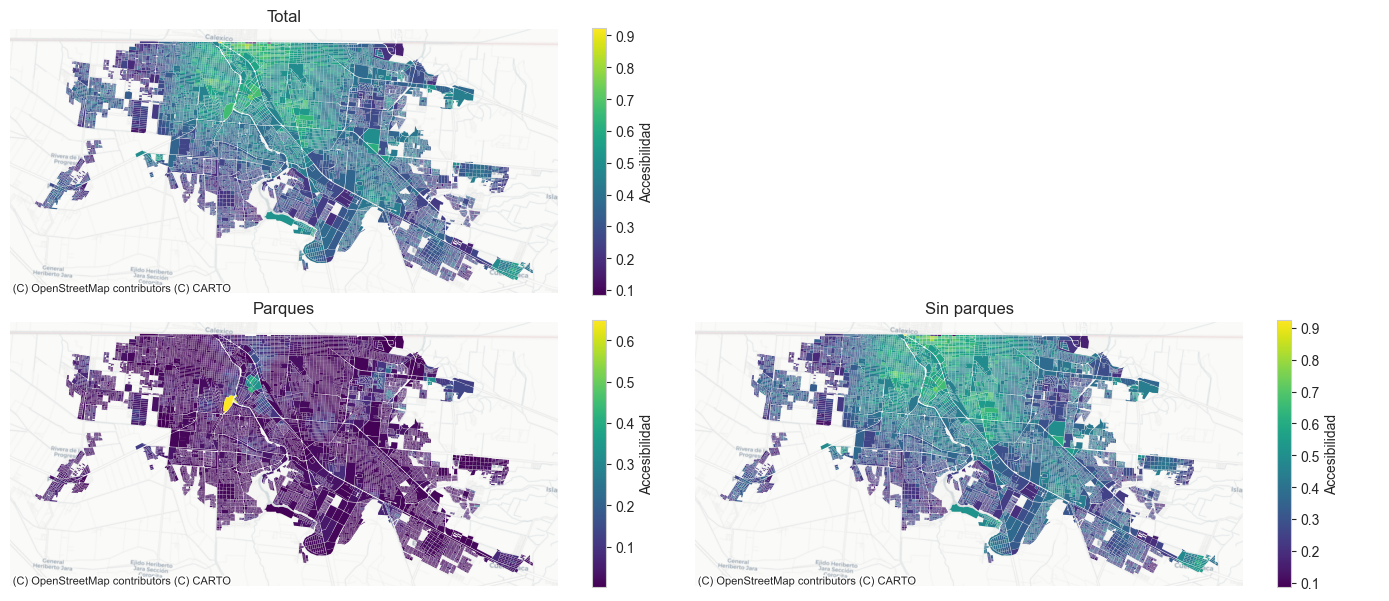

In [110]:
fig, axes = plt.subplots(2, 2, figsize=(14, 6))
res_all.plot(column="accessibility_score", legend=True, legend_kwds={"label": "Accesibilidad"}, ax=axes[0, 0], cmap="viridis", lw=0)
res_park.plot(column="accessibility_score", legend=True, legend_kwds={"label": "Accesibilidad"}, ax=axes[1, 0], cmap="viridis", lw=0)
res_non_park.plot(column="accessibility_score", legend=True, legend_kwds={"label": "Accesibilidad"}, ax=axes[1, 1], cmap="viridis", lw=0)

axes[0, 0].set_title("Total")
axes[1, 0].set_title("Parques")
axes[1, 1].set_title("Sin parques")

for i, ax in enumerate(axes.flat):
    ax.axis("off")
    if i != 1:
        cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=res_all.crs)
fig.tight_layout()
# fig.savefig("./figures/accessibility.png", bbox_inches="tight", dpi=200)

In [ ]:
def group_accessibility(res_df: gpd.GeoDataFrame, df_census: gpd.GeoDataFrame):
    grouped = (
        res_df[["weighted", "pobtot", "geometry"]]
        .sjoin(df_census, how="inner", predicate="within")
        .groupby("CVEGEO_right")
    )

    return grouped["weighted"].sum() / grouped["pobtot"].sum()

In [ ]:
df_census["accessibility"] = group_accessibility(res_all, df_census)

# Routes

In [ ]:
df_routes = (
    gpd.read_file(data_path / "RUTA_TRANSP_URB/ruta_transp_urb.shp")
    .drop(columns=["OBJECTID"])
    .to_crs("EPSG:6372")
    .assign(geometry=lambda df: df.simplify(2))
)

In [ ]:
all_map = {
    "ATUSA - Naranjos": (30, 40, 5),
    "ATUSA - Ruta09": (10, 15, 40),
    "ATUSA-Portales-Barcelona": (np.nan, np.nan, np.nan),
    "ATUSA-Portales-Voluntad": (np.nan, np.nan, np.nan),
    "AYB - Carranza": (180, 190, 1),
    "AYB - Consty": (60, 70, 2),
    "AYB - LE1": (20, 25, 9),
    "AYB - Valle Dorado": (25, 30, 8),
    "Amilpa - Alarcon-Garita Nueva": (30, 50, 6),
    "Amilpa - cetys-9na": (15, 20, 14),
    "Azul y Blanco - Buenos Aires-Hidalgo": (60, 65, 3),
    "Estrella del Norte - PROGRESO": (40, 60, 5),
    "FV - Comandancia": (15, 20, 11),
    "MB03 VALLE DE LAS MISIONES-ORIZABA-CENTRO CIVICO-INDEPENDENCIA-CORREDOR PALACO CONSECIONADO P.O. 4 DE NOVIEMBRE DE 2013.": (30, 40, 2),
    "TC02 VALLE DE PUEBLA-VILLA VERDE-CENTRO CIVICO-CENTRO CONSECIONADO P.O. 3 DE DICIEMBRE DE 2010.": (np.nan, np.nan, 1),
    "Cachanilla - EJE": (10, 15, 18)
}

freq_map = {key: (value[0] + value[1]) / 2 for key, value in all_map.items()}
count_map = {key: value[2] for key, value in all_map.items()}

df_routes["frequency"] = df_routes["Name"].map(freq_map).fillna(60)
df_routes["count"] = df_routes["Name"].map(count_map)
df_routes["rank"] = df_routes["frequency"].rank(method="dense", ascending=False)

In [ ]:
total_lengths = {}
for idx, geom in df_census["geometry"].items():
    clipped = df_routes.clip(geom)
    weighted = clipped.length * clipped["rank"]
    total_lengths[idx] = weighted.sum()

df_census["roads"] = total_lengths
df_census["roads"] = df_census["roads"] / df_census.area

In [ ]:
ox.settings.bidirectional_network_types = ["walk", "drive"]

gbi = ox.graph_from_bbox(bbox=bounds_latlon, network_type="drive")
gbi = ox.convert.to_undirected(gbi)
df_all_roads = ox.graph_to_gdfs(gbi, node_geometry=False)

# Crimes

In [ ]:
df_crime = (
    gpd.read_file(data_path / "num_delitos_ageb/num_delitos_ageb.shp")
    .to_crs("EPSG:6372")
    .set_index("CVEGEO")
    .loc[df_census.index, "num_delito"]
)

df_census["crimes_pc"] = df_crime
df_census["crimes_pc"] = df_census["crimes_pc"] / df_census["POBTOT"]

# Colonias

In [ ]:
df_col = gpd.read_file(data_path / "lim_cols_cp/lim_cols_cp.shp")[["COLONIAS", "geometry"]].to_crs("EPSG:6372").sjoin(wanted_agebs[["geometry"]], how="inner", predicate="intersects")
df_col = df_col[~df_col.index.duplicated()]

In [ ]:
df_col.COLONIAS.sort_values().to_csv("col.csv", index=False)

<Axes: >

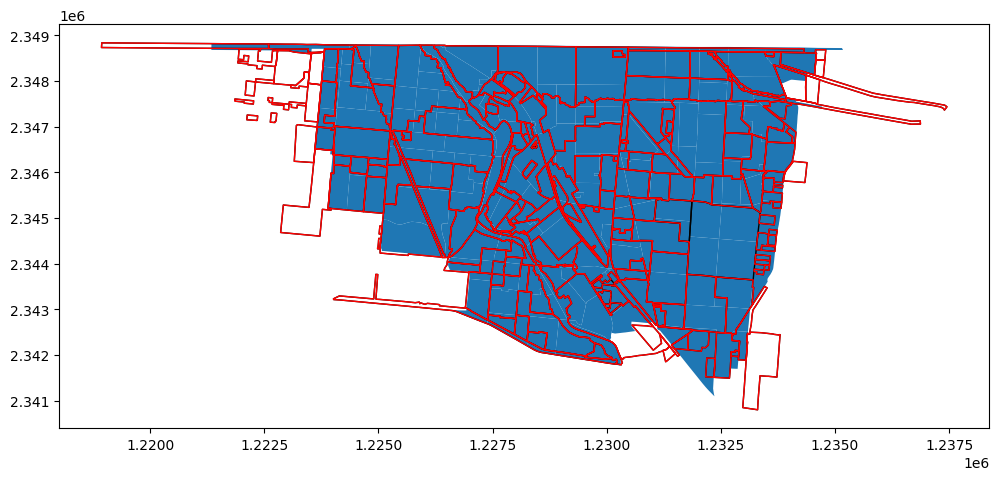

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
wanted_agebs.plot(ax=ax)
df_col.plot(fc="none", ax=ax)
df_col.drop_duplicates(subset=["COLONIAS"]).plot(fc="none", ec="r", ax=ax)

# Ranks

In [ ]:
col_labels = {
    "frac_viv_deshab": "% viviendas deshab.",
    "income_pc": "Ingreso per cápita",
    "over_60_frac": "% población >60",
    "job_frac": "Accs. trabajos",
    "num_equip": "# equipamientos",
    "rec_area": "% de área de infraestructura pública",
    "num_anchor": "# comercios ancla",
    "average_value": "Valor catastral prom.",
    "median_area": "Prom. área predios",
    "bare_frac": "% área baldía",
    "accessibility": "Accesibilidad",
    "pop_dens": "Densidad de población",
    "small_employee_density": "Densidad de empleados de comercios al por menor",
    "roads": "Densidad de rutas",
    "crimes_pc": "Delitos per cápita"
}

df_analysis = (
    df_census
    .drop(columns=["GRAPROES", "frac_viv_inter", "geometry", "num_anchor", "num_equip", "POBTOT"])
    .fillna(0)
)
df_analysis.columns = [col_labels[c] for c in df_analysis.columns]

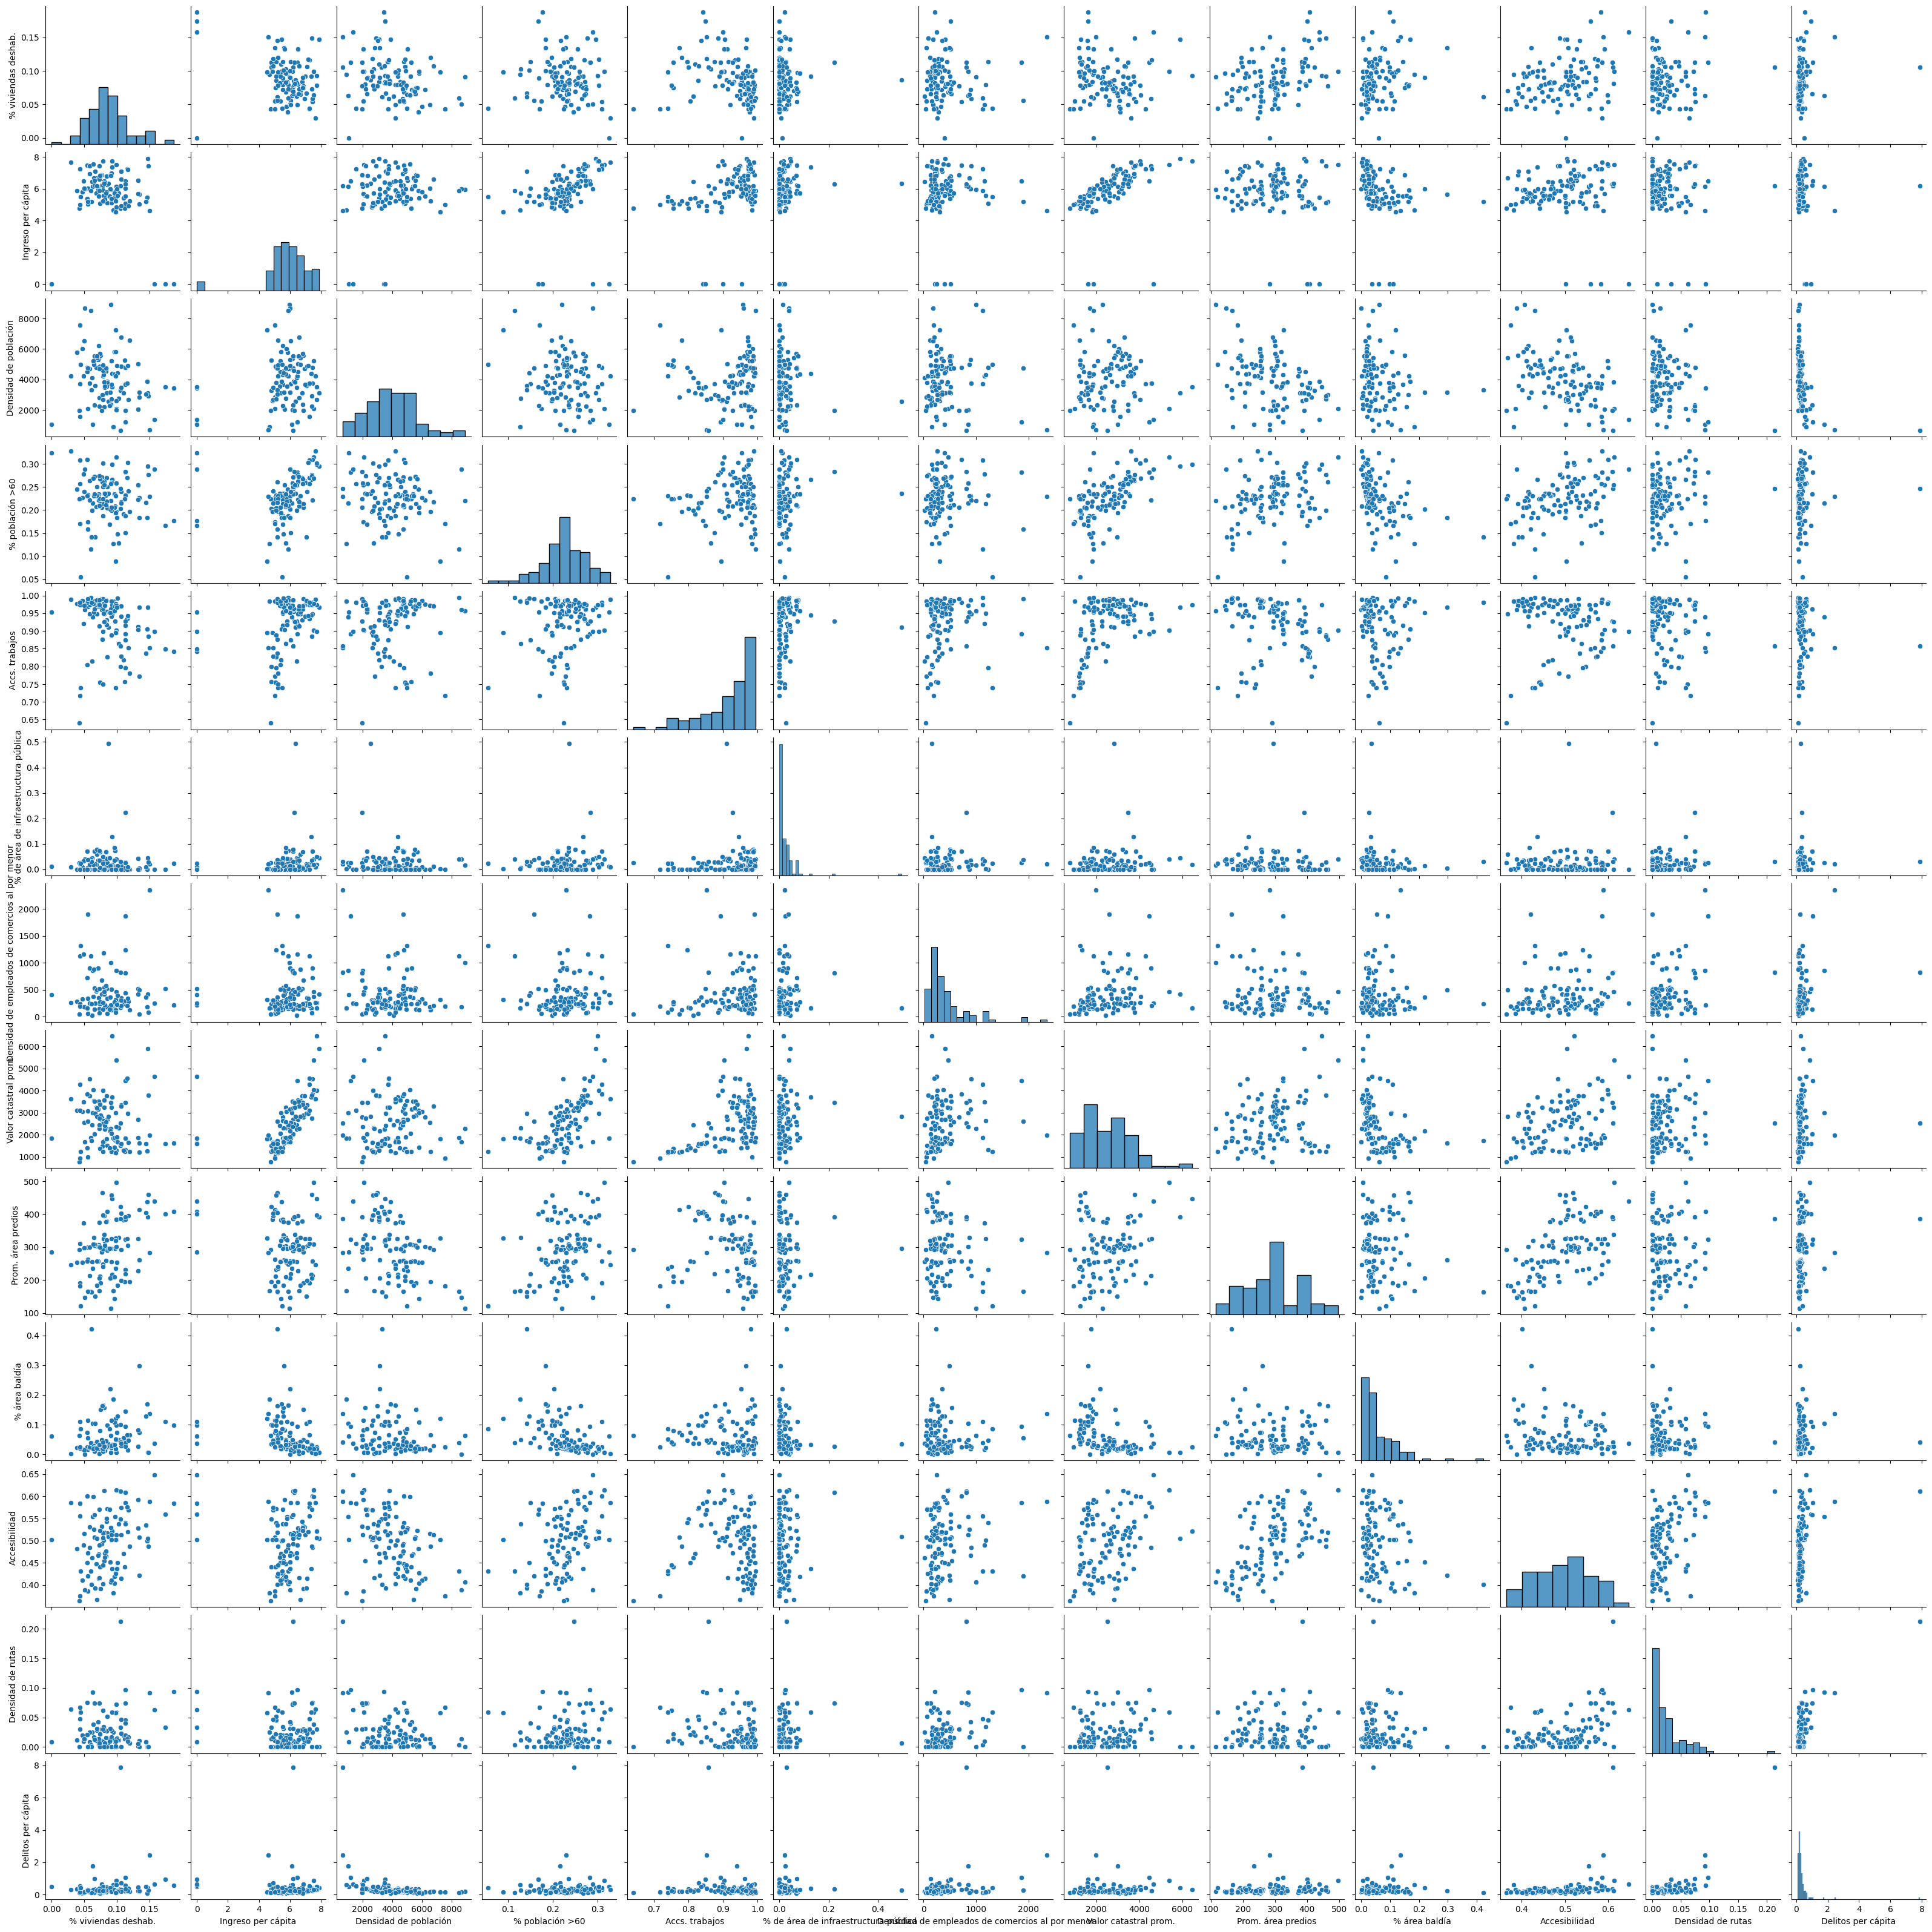

In [ ]:
df_analysis_plot = df_analysis.copy()

fig = sns.pairplot(df_analysis_plot)
fig.savefig("./figures/pairplot.png", bbox_inches="tight", dpi=200)

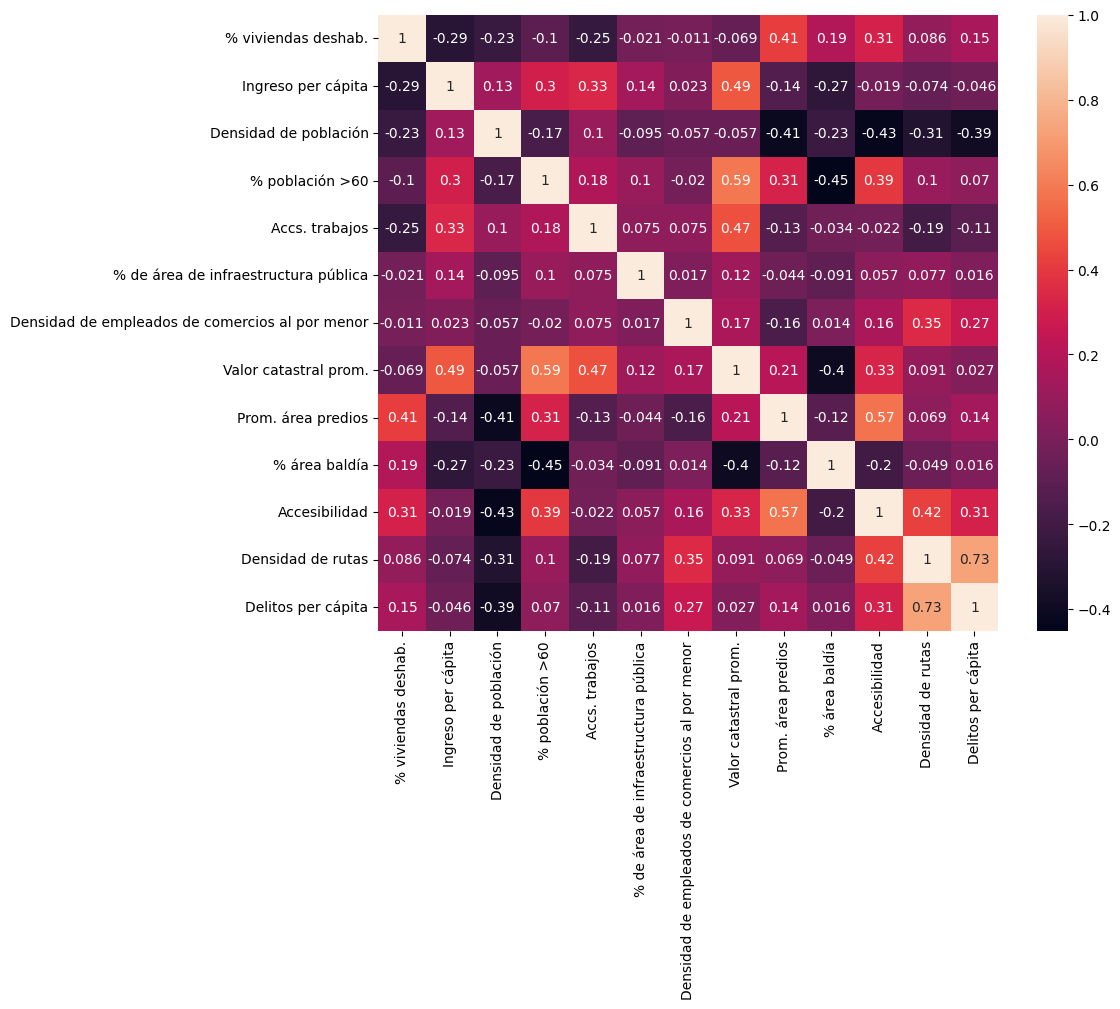

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df_analysis.corr(), annot=True, ax=ax)
fig.savefig("./figures/corr.png", bbox_inches="tight", dpi=200)

In [ ]:
df_map = df_analysis.copy()
df_map = (
    gpd.GeoDataFrame(pd.concat([df_map, df_census[["geometry"]]], axis=1), crs="EPSG:6372", geometry="geometry")
    .drop(columns=["Accs. trabajos"])
)
df_map["Ingreso per cápita"] = df_map["Ingreso per cápita"].replace({0: np.nan})

def plot_columns(
    df_map: gpd.GeoDataFrame, 
    start: int, 
    end: int,
    *,
    legend_kwds: Optional[dict[str, dict]]=None, 
    titles: Optional[dict[str, str]]=None,
    bins: Optional[dict[str, list[float]]]=None,
    schemes: Optional[dict[str, str]]=None,
    categorical: bool=False,
    df_district: Optional[gpd.GeoDataFrame]=None
):
    if legend_kwds is None:
        legend_kwds = {}

    if titles is None:
        titles = {}

    if bins is None:
        bins = {}

    if schemes is None:
        schemes = {}

    fig, axes = plt.subplots(2, 2, figsize=(12, 6))
    for col, ax in zip(df_map.drop(columns=["geometry"]).columns[start:end], axes.flat):
        if col in legend_kwds:
            kwds = legend_kwds[col]
        else:
            kwds = None
    
        if col in bins:
            classification_kwds = {"bins": bins[col]}
            scheme = "user_defined"
        else:
            classification_kwds = None
            scheme = None

        if col in schemes:
            scheme = schemes[col]

        df_map[[col, "geometry"]].plot(ax=ax, column=col, legend=True, legend_kwds=kwds, classification_kwds=classification_kwds, scheme=scheme, categorical=categorical, cmap="viridis")
        ax.axis("off")

        if col in titles:
            ax.set_title(titles[col])
        else:
            ax.set_title(col)
        cx.add_basemap(ax=ax, crs=df_map.crs, source=cx.providers.CartoDB.Positron)

        if df_district is not None:
            df_district.plot(ax=ax, facecolor="none", ec="k", lw=0.5)
        
    total_plots = end - start
    if total_plots < 4:
        for idx in range(3, total_plots - 1, -1):
            axes.flat[idx].axis("off")
    fig.tight_layout()
    return fig

In [ ]:
district_path = Path(data_path / "sector_dist40/sector_dist40.shp")
df_district = gpd.read_file(district_path).to_crs("EPSG:6372")

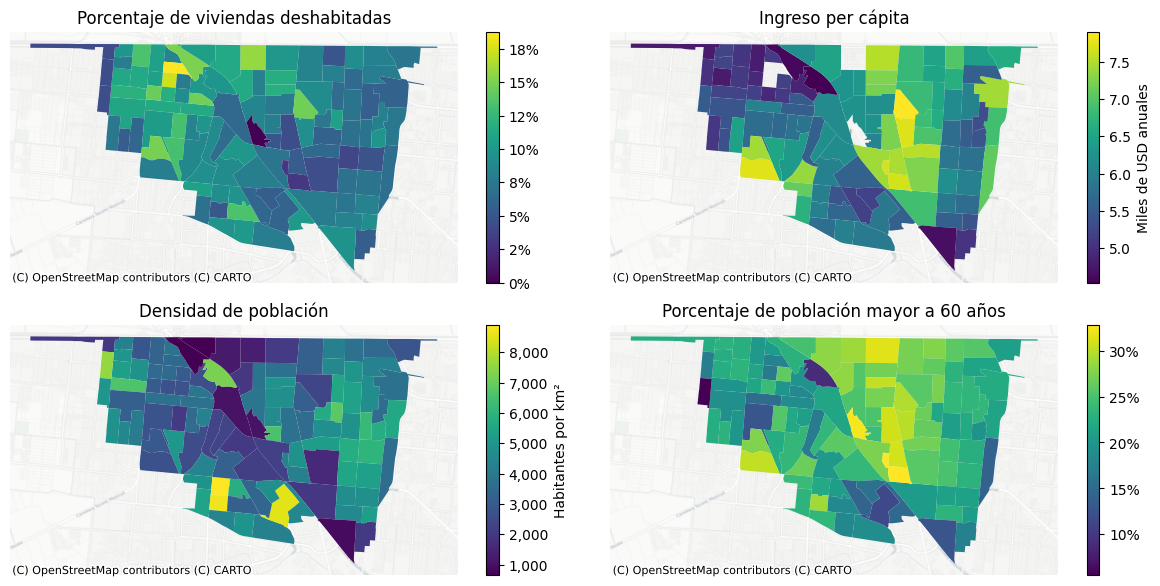

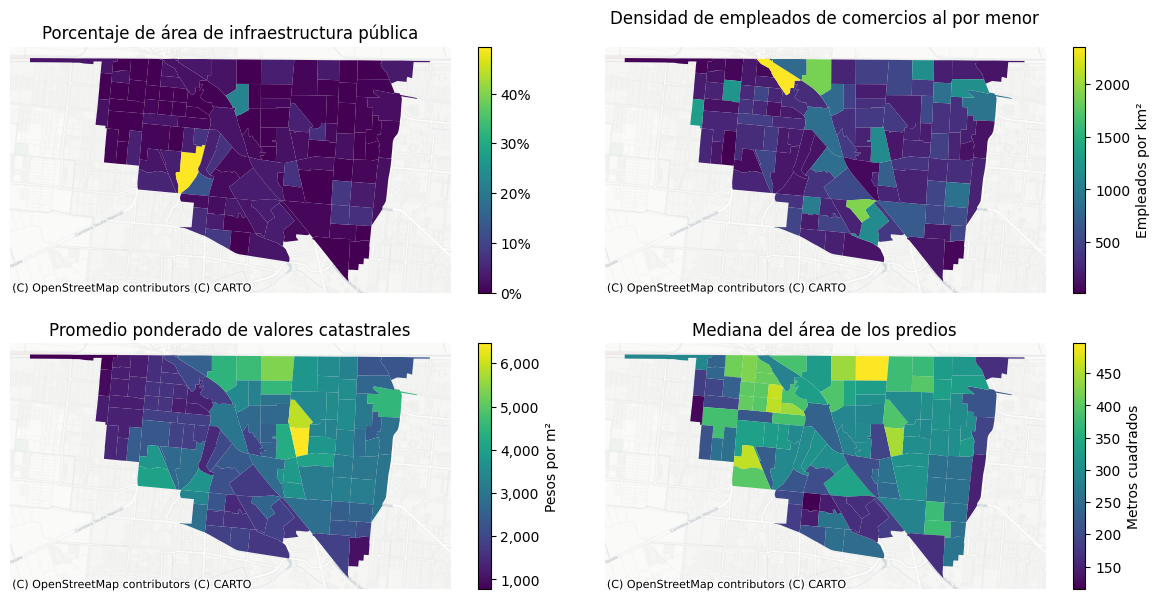

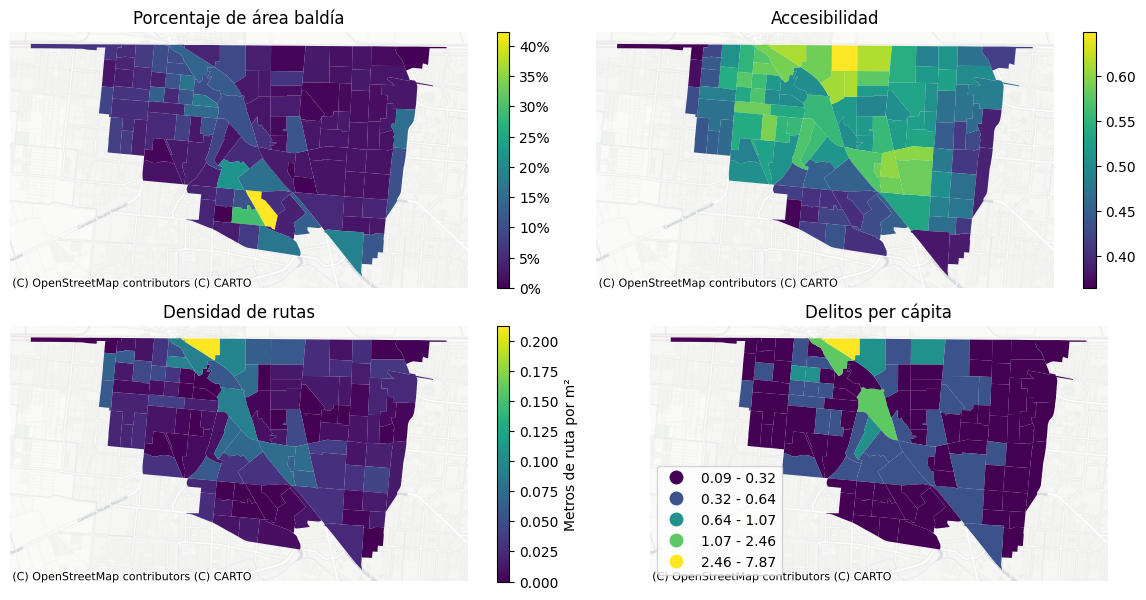

In [ ]:
legend_kwds = {
    "% viviendas deshab.": {
        "format": mtick.PercentFormatter(1, decimals=0)
    },
    "Ingreso per cápita": {
        "label": "Miles de USD anuales"
    },
    "% población >60":{
        "format": mtick.PercentFormatter(1, decimals=0)
    },
    "% de área de infraestructura pública": {
        "format": mtick.PercentFormatter(1, decimals=0)
    },
    "Valor catastral prom.": {
        "format": mtick.StrMethodFormatter("{x:,.0f}"),
        "label": "Pesos por m²"
    },
    "Prom. área predios": {
        "label": "Metros cuadrados"
    },
    "Densidad de rutas": {
        "label": "Metros de ruta por m²"
    },
    "Densidad de población": {
        "label": "Habitantes por km²",
        "format": mtick.StrMethodFormatter("{x:,.0f}"),
    },
    "% área baldía": {
        "format": mtick.PercentFormatter(1, decimals=0)
    },
    "Densidad de empleados de comercios al por menor": {
        "label": "Empleados por km²"
    },
    "Delitos": {
        "format": mtick.StrMethodFormatter("{x:,.0f}"),
    },
}

titles = {
    "% viviendas deshab.": "Porcentaje de viviendas deshabitadas",
    "% población >60": "Porcentaje de población mayor a 60 años",
    "% de área de infraestructura pública": "Porcentaje de área de infraestructura pública",
    "# equipamientos": "Número de equipamientos",
    "# comercios ancla": "Número de comercios ancla",
    "Valor catastral prom.": "Promedio ponderado de valores catastrales",
    "Prom. área predios": "Mediana del área de los predios",
    "Accs. trabajos": "Porcentaje de trabajos accesibles",
    "% área baldía": "Porcentaje de área baldía",
}

schemes = {
    "Delitos per cápita": "natural_breaks"
}

for i, (start, end) in enumerate(zip([0, 4, 8], [4, 8, 12])):
    for subpath, d in zip(["normal"], [None]):
        fig = plot_columns(df_map, start, end, legend_kwds=legend_kwds, titles=titles, schemes=schemes, df_district=d)

        for ax in fig.get_axes():
            title = ax.get_title()
            if title in schemes.keys() and schemes[title] == "natural_breaks":
                leg = ax.get_legend()                
                for text_meta in leg.get_texts():
                    text_str = " - ".join(text_meta.get_text().split(", "))
                    text_meta.set_text(text_str)
                leg.set_loc("lower left")
        
        fig.savefig(f"./figures/maps/{subpath}/map_{i}.png", bbox_inches="tight", dpi=200)
                
        # plt.close()

In [ ]:
df_analysis = df_analysis.drop(columns=["Delitos per cápita"])

In [ ]:
category_order = {
    "% viviendas deshab.": "larger",
    "Ingreso per cápita": "smaller",
    "Densidad de población": "middle",
    "% población >60": "larger",
    "Accs. trabajos": "larger",
    "% de área de infraestructura pública": "larger",
    "Densidad de empleados de comercios al por menor": "larger",
    "Valor catastral prom.": "smaller",
    "Prom. área predios": "larger",
    "% área baldía": "larger",
    "Densidad de rutas": "larger",
    "Accesibilidad": "larger",
}

category_points = {
    "Densidad de población": 10,
    "% viviendas deshab.": 10,
    "% área baldía": 10,
    "Accesibilidad": 10,
    "% de área de infraestructura pública": 5,
    "Densidad de empleados de comercios al por menor": 5,
    "Valor catastral prom.": 10,
    "Prom. área predios": 10,
    "Ingreso per cápita": 5,
    "Accs. trabajos": 10,
    "% población >60": 5,
    "Densidad de rutas": 10
}

def rank_col_by_quintile_ordered(col: pd.Series, *, which_is_better: str, total_points: float) -> pd.Series:
    num_partitions = 5
    
    qvals = np.linspace(1 / num_partitions, (num_partitions - 1) / num_partitions, num_partitions - 1)
    quantiles = [col.quantile(i) for i in qvals]

    points = [total_points / (num_partitions - 1) * i for i in range(1, num_partitions - 1)]
    q0, q1 = col.quantile(0), col.quantile(0.2)
    if q0 == q1:
        points[0] = 0

    if which_is_better == "smaller":
        points = points[::-1]

    out = col.copy()
    out[:] = 0
    for start, end, p in zip(quantiles, quantiles[1:], points):
        mask = (start <= col) & (col < end)
        out += mask * p

    if which_is_better == "larger":
        mask_end = col >= quantiles[-1]
    elif which_is_better == "smaller":
        mask_end = col < quantiles[0]
    out += mask_end * total_points

    return out


def rank_col_by_quintile_bell(col: pd.Series, *, total_points: float) -> pd.Series:
    out = col.copy()
    out[:] = 0
    
    for qleft, qright, points in [(0.2, 0.4, total_points / 2), (0.4, 0.6, total_points), (0.6, 0.8, total_points / 2)]:
        left = col.quantile(qleft)
        right = col.quantile(qright)   
        mask = (left <= col) & (col < right)
        out += mask * points
    return out


def rank_col_by_quintile_dispatcher(col: pd.Series, *, which_is_better: str, total_points: float) -> pd.Series:
    if which_is_better == "larger" or which_is_better == "smaller":
        return rank_col_by_quintile_ordered(col, which_is_better=which_is_better, total_points=total_points)
    else:
        return rank_col_by_quintile_bell(col, total_points=total_points)

In [ ]:
def generate_rank_df(df_analysis: pd.DataFrame, geometry: gpd.GeoSeries, *, points_map: dict[str, float], order_map: dict[str, bool]):
    df_rank = df_analysis.copy()
    for col in df_rank.columns:
        if col == "geometry":
            continue
        order = order_map[col]
        p = points_map[col]
        df_rank[col] = rank_col_by_quintile_dispatcher(df_rank[col], which_is_better=order, total_points=p)

    df_rank["geometry"] = geometry
    df_rank = gpd.GeoDataFrame(df_rank, crs=geometry.crs, geometry="geometry")
    return df_rank


def permute_dict(d: dict, generator: Optional[np.random.Generator]=None):
    if generator is None:
        generator = np.random.default_rng()
    perm = generator.permutation(list(d.values()))
    out = {key: value for key, value in zip(d.keys(), perm)}
    return out

In [ ]:
df_rank = generate_rank_df(
    df_analysis, 
    df_census["geometry"], 
    points_map=category_points, 
    order_map=category_order
)

In [ ]:
ran = lambda x: [i * x / 5 for i in range(5)]

bins = {
    "% viviendas deshab.": ran(10),
    "Ingreso per cápita": ran(5),
    "% población >60": ran(5),
    "Accs. trabajos": ran(15),
    "# equipamientos": ran(10),
    "% de área de infraestructura pública": ran(5),
    "# comercios ancla": ran(10),
    "Valor catastral prom.": ran(10),
    "Prom. área predios": ran(10),
    "% área baldía": ran(5)
}

for i, (start, end) in enumerate(zip([0, 4, 8], [4, 8, 11])):
    for subpath, d in zip(["normal", "overlay"], [None, df_district]):
        fig = plot_columns(df_rank, start, end, titles=titles, categorical=True, df_district=d)
        for ax in fig.get_axes():
            leg = ax.get_legend()
            if leg is not None:
                leg.set_bbox_to_anchor((1, 1, 0.21, 0))

        fig.savefig(f"./figures/maps/{subpath}/ranking_{i}.png", bbox_inches="tight", dpi=200)
        plt.close()

In [ ]:
def generate_tally_df(df_rank: gpd.GeoDataFrame):
    sums = df_rank.drop(columns=["geometry"]).sum(axis=1)
    df_plot_final = gpd.GeoDataFrame(
        pd.concat([sums, df_census["geometry"]], axis=1), 
        crs=df_census.crs, 
        geometry="geometry"
    )
    return df_plot_final

In [ ]:
def plot_final_ranks(df_rank: gpd.GeoDataFrame, *, ax):
    df_plot_final = generate_tally_df(df_rank)
    df_plot_final = df_plot_final.assign(coords=lambda x: x.geometry.centroid.apply(lambda x: x.coords[:][0]))

    for _, row in df_plot_final.iterrows():
        if row[0] < 45:
            textcolor = "w"
        else:
            textcolor = "k"
        ax.annotate(f"{row[0]:.0f}", xy=row["coords"], ha="center", fontsize=8, color=textcolor, va="center")

    df_plot_final.plot(column=0, legend=True, ax=ax, cmap="cividis", ec="k", lw=0.1)
    cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=df_census.crs, zoom=14)
    ax.axis("off")
    ax.set_title("Puntuaciones finales")

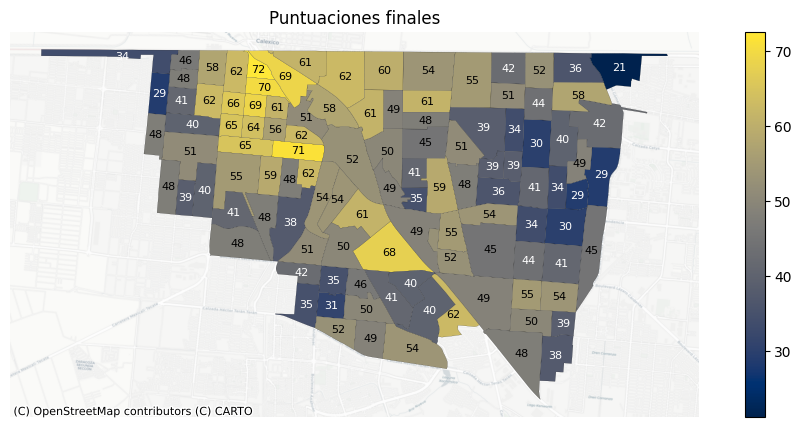

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
plot_final_ranks(df_rank, ax=ax)
fig.savefig("./figures/maps/normal/final_ranking.png", bbox_inches="tight", dpi=200)

# df_district.plot(ax=ax, lw=0.5, ec="k", fc="none")
# fig.savefig("./figures/maps/overlay/final_ranking.png", bbox_inches="tight", dpi=200)

In [ ]:
num_iter = 10_000
gen = np.random.default_rng(42)

ranks = []
for i in range(num_iter):
    perm = permute_dict(category_points, gen)
    df_perm = generate_rank_df(df_analysis, df_census["geometry"], points_map=perm, order_map=category_order)
    df_tally_perm = generate_tally_df(df_perm)
    r = (
        df_tally_perm[0]
        .rank(ascending=False)
    )
    r.name = i
    ranks.append(r)

    # fig, ax = plt.subplots(figsize=(12, 5))
    # df_tally_perm.plot(column=0, cmap="cividis", ax=ax, legend=True)
    # ax.axis("off")
ranks = pd.concat(ranks, axis=1)

In [ ]:
partition_size = 10

def column_to_range(col: float, partition_size: int, total_size: int) -> str:
    end_offset = partition_size
    if col + end_offset > total_size:
        end_offset = total_size - col
    return f"{int(col + 1)} - {int(col + end_offset)}"

def range_to_column(r: str) -> float:
    return int(r.split("-")[0].strip()) - 1

df_rank_montecarlo = (ranks - 1) // partition_size * partition_size
df_rank_montecarlo = (
    df_rank_montecarlo
    .melt(ignore_index=False)
    .reset_index()
    .groupby(["CVEGEO", "value"])
    ["variable"]
    .count()
    .reset_index()
    .pivot(index="CVEGEO", columns="value", values="variable")
    / num_iter
)
idmax = df_rank_montecarlo.idxmax(axis=1)
valmax = df_rank_montecarlo.max(axis=1)
df_rank_montecarlo = gpd.GeoDataFrame(pd.concat([idmax, df_census["geometry"]], axis=1), crs=df_census.crs, geometry="geometry")

df_rank_montecarlo = df_rank_montecarlo.assign(coords=lambda x: x.geometry.centroid.apply(lambda x: x.coords[:][0]))
df_rank_montecarlo["text"] = valmax

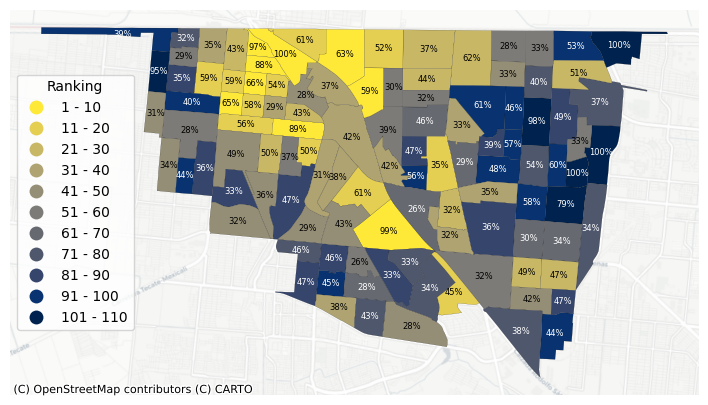

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
df_rank_montecarlo.plot(column=0, categorical=True, legend=True, cmap="cividis_r", ax=ax, ec="k", lw=0.1)
for _, row in df_rank_montecarlo.iterrows():
    if row[0] > 50:
        textcolor = "w"
    else:
        textcolor = "k"
    ax.annotate(f"{row['text']:.0%}", xy=row["coords"], ha="center", fontsize=6, color=textcolor, va="center")

ax.axis("off")
leg = ax.get_legend()
for t in leg.get_texts():
    t.set_text(column_to_range(float(t.get_text()), partition_size=partition_size, total_size=len(df_census)))
leg.set_title("Ranking")
cx.add_basemap(ax=ax, crs=df_rank_montecarlo.crs, source=cx.providers.CartoDB.Positron)
fig.savefig("./figures/maps/normal/percents.png", bbox_inches="tight", dpi=200)

# df_district.plot(ax=ax, ec="gray", lw=0.5, fc="none", linestyle="-")
# fig.savefig("./figures/maps/overlay/percents.png", bbox_inches="tight", dpi=200)

In [ ]:
(
    df_rank_montecarlo
    .rename(columns={0: "rank"})
    .assign(text=lambda df: df.text.apply(lambda x: f"{x:.0%}"))
    .to_file("montecarlo.gpkg")
)

# Extra figures

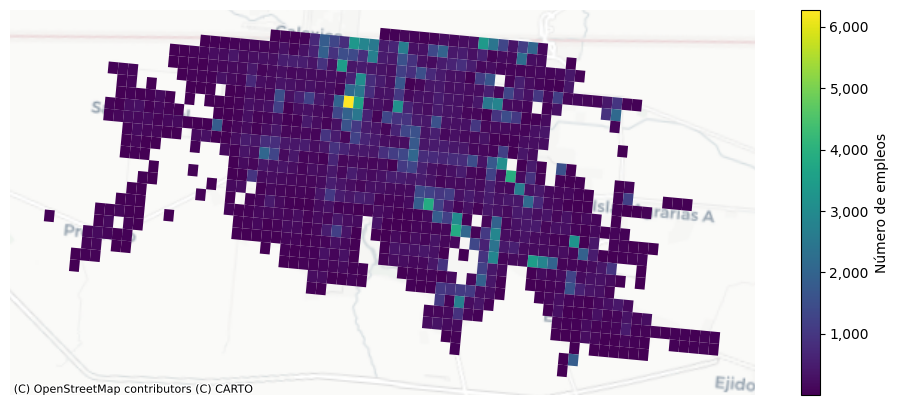

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5))
jobs.plot(column="num_empleos", ax=ax, legend=True, legend_kwds={"label": "Número de empleos", "format": "%0d"})
ax.axis("off")
cbar = fig.get_axes()[-1]
cbar.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))
cx.add_basemap(ax=ax, source=cx.providers.CartoDB.Positron, crs=jobs.crs)
# fig.savefig("./figures/job_density.png", bbox_inches="tight", dpi=200)

# HTML

In [ ]:
df_map_temp = df_map.copy()
df_map_temp.columns = [titles[c] if c in titles else c for c in df_map_temp.columns]

df_html = pd.concat([
    (
        df_rank_montecarlo
        .rename(columns={0: "Rango de ranking", "text": "Fracción de permutaciones"})
        .assign(ranking_range=lambda x: x["Rango de ranking"].apply(lambda y: column_to_range(y, partition_size=partition_size, total_size=len(df_census))))
        .drop(columns=["coords", "Rango de ranking"])
        .rename(columns={"ranking_range": "Rango de ranking"})
        .to_crs("EPSG:4326")
    ),
    (
        df_plot_final
        .rename(columns={0: "Puntuación"})
        .drop(columns=["geometry", "coords"])
    ),
    df_map_temp.drop(columns=["geometry"]),
    df_census[["job_frac"]].rename(columns={"job_frac": "Porcentaje de empleos accesibles"}),
], axis=1).reset_index()

NameError: name 'df_plot_final' is not defined

In [ ]:
df_html.to_file("./products/polygons.gpkg")
df_html.drop(columns=["geometry"]).set_index("CVEGEO").to_excel("./products/attributes.xlsx")
df_html

CVEGEO                                           geometry  \
0    0200200010042  MULTIPOLYGON (((-115.5056 32.66431, -115.50561...   
1    0200200010057  MULTIPOLYGON (((-115.5056 32.66431, -115.5025 ...   
2    0200200010095  MULTIPOLYGON (((-115.45253 32.6682, -115.45255...   
3    0200200010108  MULTIPOLYGON (((-115.44314 32.65854, -115.4430...   
4    0200200010165  MULTIPOLYGON (((-115.50942 32.6573, -115.50898...   
..             ...                                                ...   
101  0200200015753  MULTIPOLYGON (((-115.51197 32.65996, -115.5119...   
102  0200200015768  MULTIPOLYGON (((-115.50312 32.65183, -115.5043...   
103  0200200015772  MULTIPOLYGON (((-115.50433 32.65183, -115.5031...   
104  0200200016747  MULTIPOLYGON (((-115.51847 32.6586, -115.51847...   
105  0200200016751  MULTIPOLYGON (((-115.51847 32.64822, -115.5184...   

     Fracción de permutaciones Rango de ranking  Puntuación  \
0                        0.611          11 - 20       61.25   
1                        0.386          21 - 30       57.50   
2                        0.452          11 - 20       60.00   
3                        0.534          11 - 20       58.75   
4                        0.377          31 - 40       53.75   
..                         ...              ...         ...   
101                      0.462          71 - 80       40.00   
102                      0.420          21 - 30       57.50   
103                      0.384          21 - 30       56.25   
104                      1.000        101 - 106       21.25   
105                      0.373          81 - 90       37.50   

     Porcentaje de viviendas deshabitadas  Ingreso per cápita  \
0                                0.134100            5.048268   
1                                0.105714            4.788611   
2                                0.099371            7.528908   
3                                0.084034            6.783104   
4                                0.113272            5.090818   
..                                    ...                 ...   
101                              0.078695            5.228769   
102                              0.107034            4.925840   
103                              0.144828            5.173517   
104                              0.043237            5.012917   
105                              0.044170            5.496253   

     Porcentaje de población mayor a 60 años  Número de equipamientos  \
0                                   0.227378                     10.0   
1                                   0.202730                      8.0   
2                                   0.314992                     82.0   
3                                   0.270595                     62.0   
4                                   0.231934                      8.0   
..                                       ...                      ...   
101                                 0.224756                      9.0   
102                                 0.215663                     11.0   
103                                 0.216968                      1.0   
104                                 0.170669                      3.0   
105                                 0.055464                      6.0   

     Porcentaje de área recreativa  Número de comercios ancla  \
0                         0.000000                        2.0   
1                         0.000000                        0.0   
2                         0.025894                        8.0   
3                         0.004693                        9.0   
4                         0.000000                        1.0   
..                             ...                        ...   
101                       0.015859                        0.0   
102                       0.000000                        0.0   
103                       0.005924                        0.0   
104                       0.000000                        0.0   
105  

In [ ]:
fig = px.choropleth_map(
    df_html, 
    geojson=df_html.geometry, 
    locations=df_html.index, 
    width=1200, 
    height=800, 
    map_style="carto-positron", 
    center={"lat": 32.6345, "lon": -115.4723},
    zoom=12,
    color="Puntuación",
    opacity=0.7,
    custom_data=[
        "CVEGEO", 
        "Ingreso per cápita", 
        "Porcentaje de viviendas deshabitadas", 
        "Porcentaje de población mayor a 60 años",
        "Número de equipamientos",
        "Porcentaje de área recreativa",
        "Número de comercios ancla",
        "Promedio ponderado de valores catastrales",
        "Mediana del área de los predios",
        "Porcentaje de área baldía",
        "Accesibilidad",
        "Porcentaje de empleos accesibles",
        "Fracción de permutaciones",
        "Rango de ranking"
    ]
)
fig.update_traces(
    hovertemplate=(
"""
<b>%{customdata[0]}</b>
<br>
<br>
Ingreso per cápita (miles de dls. anuales): %{customdata[1]:$,.2f}
<br>
Porcentaje de viviendas deshabitadas: %{customdata[2]:.0%}
<br>
Porcentaje de población mayor a 60 años %{customdata[3]:.0%}
<br>
Número de equipamientos: %{customdata[4]}
<br>
Porcentaje de área recreativa: %{customdata[5]:.0%}
<br>
Número de comercios ancla: %{customdata[6]}
<br>
Promedio ponderado de valores catastrales: %{customdata[7]:,.0f} $/m²
<br>
Mediana del área de los predios: %{customdata[8]:,.0f}
<br>
Porcentaje de área baldía: %{customdata[9]:,.0%}
<br>
Accesibilidad: %{customdata[10]:,.2f}
<br>
Porcentaje de empleos accesibles: %{customdata[11]:.0%}
<br>
Fracción de permutaciones: %{customdata[12]:.0%}
<br>
Rango de ranking: %{customdata[13]}
"""
    )
)
fig.show()
fig.write_html("./products/map.html")

# Scenarios

In [ ]:
scenario_points = {
    "Densidad de población": [5, 5, 5, 10, 10, 10],
    "% viviendas deshab.": [20, 5, 5, 20, 5, 5],
    "% área baldía": [20, 5, 5, 20, 5, 5],
    "Accesibilidad": [5, 30, 10, 5, 5, 10],
    "% de área de infraestructura pública": [5, 10, 30, 5, 5, 10],
    "Densidad de empleados de comercios al por menor": [5, 10, 10, 5, 20, 10],
    "Valor catastral prom.": [10, 5, 5, 5, 5, 5],
    "Prom. área predios": [10, 5, 5, 10, 5, 5],
    "Ingreso per cápita": [5, 5, 5, 5, 10, 5],
    "Accs. trabajos": [5, 5, 5, 5, 20, 5],
    "% población >60": [5, 5, 5, 5, 5, 5],
    "Densidad de rutas": [5, 10, 10, 5, 5, 20]
}
scenario_points_exploded = [{key: value[i] for key, value in scenario_points.items()} for i in range(len(list(scenario_points.values())[0]))]

scenario_df = pd.DataFrame(scenario_points_exploded).T

In [ ]:
for i in range(len(scenario_points_exploded)):
    df_scenario = generate_rank_df(
        df_analysis,
        df_census["geometry"], 
        points_map=scenario_points_exploded[i], 
        order_map=category_order
    )

    fig, (axl, axr) = plt.subplots(1, 2, figsize=(13, 5), width_ratios=(10, 1))
    plot_final_ranks(df_scenario, ax=axl)
    tab = axr.table(cellText=scenario_df[[i]].rename(columns={i: "Valor"}, index={"Densidad de empleados de comercios al por menor": "Dens. empleo al por menor"}), loc="center", cellLoc="center")
    tab.auto_set_column_width(col=scenario_df.columns)
    axr.axis("off")
    axl.set_title(f"Escenario {i + 1}")
    fig.tight_layout()
    fig.savefig(f"./figures/maps/normal/scenarios/{i}.png", bbox_inches="tight", dpi=200)

    df_district.plot(ax=axl, ec="k", fc="none", lw=0.5)
    fig.savefig(f"./figures/maps/overlay/scenarios/{i}.png", bbox_inches="tight", dpi=200)
    plt.close()

# Final polygons

In [ ]:
final_idx = gpd.read_file("./final_polygon.gpkg")["CVEGEO"]
df_final = df_census.loc[final_idx]

<Axes: >

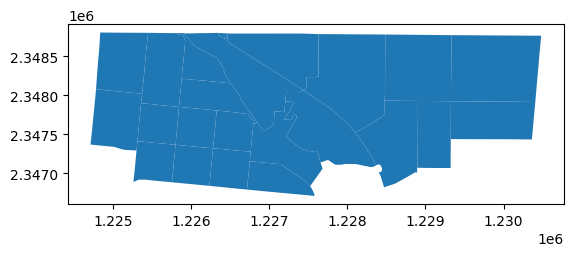

In [ ]:
df_final.plot()

# Red

In [ ]:
poly_red = gpd.read_file(data_path / "polygons/red_1.gpkg")
poly_blue = gpd.read_file(data_path / "polygons/blue.gpkg")

print(poly_red.area.item())
print(poly_blue.area.item())

4492055.150736329
4853827.461964458


In [ ]:
def calculate_polygon_pop(df_census: gpd.GeoDataFrame, polygon_df: gpd.GeoDataFrame):
    overlay = (
        df_census
        [["POBTOT", "geometry"]]
        .reset_index()
        .overlay(polygon_df)
        .set_index("CVEGEO")
        .assign(
            orig_area=df_census.area, 
            area_frac=lambda df: df.area / df.orig_area, 
            pop_frac=lambda df: df.POBTOT * df.area_frac
        )
    )
    return overlay["pop_frac"].sum()

In [ ]:
calculate_polygon_pop(df_census, poly_red)

8143.156047979088

In [ ]:
temp = Path("/Users/rodolfofigueroa/Downloads/merged")
for path in temp.glob("*.geojson"):
    df = gpd.read_file(path)
    name = path.name.replace(".geojson", "").replace(".gpkg", "")
    df.to_file(path.parent / f"{name}.geojson")
    os.remove(path)

In [ ]:
name

'M11.01'

In [ ]:
name

'M11.01.gpkg'

In [ ]:
calculate_polygon_pop(df_census, poly_blue)

12520.364285511363